In [ ]:
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import csv
import sys
import h5py
# 데이터를 담을 빈 리스트 생성
data_frames = []

print("데이터 로드 시작...")

for i in range(1, 11):
    # 1. 파일 경로 수정 (.mat 확장자 추가 및 변수명 오타 수정)
    address = f"ninapro_db5/s{i}/S{i}_E2_A1.mat"
    
    try:
        mat = sio.loadmat(address)
        
        # 2. 데이터 추출
        emg = mat['emg']
        # Ninapro 데이터셋 버전에 따라 키값이 대소문자가 다를 수 있어 안전하게 처리
        Restimulus = mat['restimulus'] if 'restimulus' in mat else mat['Restimulus']
        
        # 3. 데이터프레임 생성
        df_emg = pd.DataFrame(emg)
        df_Restimulus = pd.DataFrame(Restimulus)
        
        # 4. 옆으로 합치기 (axis=1)
        df = pd.concat([df_emg, df_Restimulus], axis=1)
        
        # 5. 컬럼명 지정
        df.columns = [f'emg{k}' for k in range(1, 17)] + ['Restimulus']
        
        # 6. 리스트에 추가 (속도 최적화)
        data_frames.append(df)
        print(f"Subject {i} Loaded.")
        
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {address}")
    except Exception as e:
        print(f"에러 발생 (Subject {i}): {e}")

# 7. 전체 데이터 하나로 병합 (루프 밖에서 한 번에 수행)
if data_frames:
    ninapro_df5 = pd.concat(data_frames, ignore_index=True)
    print("------------------------------")
    print("모든 데이터 병합 완료")
    print(f"전체 데이터 Shape: {ninapro_df5.shape}")
else:
    print("로드된 데이터가 없습니다.")
    
#ninapro2 데이터셋 불러오기
dfs = []
for i in range(1, 41):
    address = f"ninapro_db2/DB2_s{i}/S{i}_E1_A1.mat"
    try:
        mat = sio.loadmat(address)
        
        emg = mat['emg'] 
        restimulus = mat['restimulus']
        
        n_samples, n_channels = emg.shape
        target_channels = 16
        
        if n_channels < target_channels:
            pad_width = target_channels - n_channels
            zeros = np.zeros((n_samples, pad_width))
            emg_padded = np.hstack([emg, zeros])
        else:
            emg_padded = emg[:, :target_channels]
            

        col_names = [f'emg{k}' for k in range(1, target_channels + 1)]
        df_emg = pd.DataFrame(emg_padded, columns=col_names)
        df_restimulus = pd.DataFrame(restimulus, columns=['Restimulus'])
        
        df_concat = pd.concat([df_emg, df_restimulus], axis=1)
        
        dfs.append(df_concat)
    
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {address}")
    except Exception as e:
        print(f"Subject {i} 처리 중 에러 발생: {e}")

if dfs:
    ninapro_df2 = pd.concat(dfs, ignore_index=True)
    print("-" * 30)
    print("최종 병합 완료")
    print(f"전체 데이터 Shape: {ninapro_df2.shape}")
    print(f"컬럼 목록: {list(ninapro_df2.columns)}")
else:
    print("데이터가 로드되지 않았습니다.")

#nature df csv불러오는 코드
nature_df = pd.read_csv('nature_df.csv')
print(f"전체 데이터 Shape: {nature_df.shape}")

데이터 로드 시작...
Subject 1 Loaded.
Subject 2 Loaded.
Subject 3 Loaded.
Subject 4 Loaded.
Subject 5 Loaded.
Subject 6 Loaded.
Subject 7 Loaded.
Subject 8 Loaded.
Subject 9 Loaded.
Subject 10 Loaded.
------------------------------
모든 데이터 병합 완료
전체 데이터 Shape: (2023639, 17)
------------------------------
최종 병합 완료
전체 데이터 Shape: (36027660, 17)
컬럼 목록: ['emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6', 'emg7', 'emg8', 'emg9', 'emg10', 'emg11', 'emg12', 'emg13', 'emg14', 'emg15', 'emg16', 'Restimulus']


In [ ]:
import pandas as pd
import numpy as np
from scipy import signal

# 1. 그룹 ID 생성
group_id = (ninapro_df5['Restimulus'] != ninapro_df5['Restimulus'].shift()).cumsum()

# 처리된 조각들을 담을 임시 리스트
processed_segments = []

# 업샘플링 설정
target_fs = 1000
original_fs = 200
scale_factor = int(target_fs / original_fs)  # 5배

print(f"=== 구간별 업샘플링 및 1000단위 절삭 시작 ===")

for gid, segment in ninapro_df5.groupby(group_id):
    rest_value = segment['Restimulus'].iloc[0]
    original_len = len(segment)
    
    # 1. 업샘플링 후 전체 길이 계산
    full_upsampled_len = original_len * scale_factor 
    
    # 2. 1000 단위로 자를 길이 계산 (버림)
    cutoff_len = (full_upsampled_len // 1000) * 1000
    
    # 길이가 1000 미만이면 스킵
    if cutoff_len == 0:
        print(f"Group {gid}: [SKIP] Label={rest_value}, Upsampled Len={full_upsampled_len} (Too Short)")
        continue

    # 3. 리샘플링 (전체 길이로 먼저 늘림)
    resampled_data = signal.resample(segment, full_upsampled_len)
    
    # 4. DataFrame 변환
    new_segment = pd.DataFrame(resampled_data, columns=segment.columns)
    
    # 5. 1000 단위까지만 슬라이싱 (뒷부분 버림)
    new_segment = new_segment.iloc[:cutoff_len]
    
    # 라벨 보정 (리샘플링으로 인해 소수점이 된 값을 정수 라벨로 복구)
    new_segment['Restimulus'] = int(rest_value)

    # ---------------------------------------------------------
    # [요청하신 기능] 로그 출력 (Len: 업샘플링된 길이 -> 저장된 길이)
    # ---------------------------------------------------------
    counts_info = new_segment['Restimulus'].value_counts().to_dict()
    
    print(f"Group {gid}: Label={rest_value}, Len={full_upsampled_len} -> {len(new_segment)} (Saved) | Counts: {counts_info}")

    # 리스트에 추가
    processed_segments.append(new_segment)

# -------------------------------------------------------------
# 리스트를 합쳐서 'ninapro_df5'에 덮어쓰기
# -------------------------------------------------------------
if len(processed_segments) > 0:
    ninapro_df5 = pd.concat(processed_segments).reset_index(drop=True)
    print("\n=== 최종 병합 완료 ===")
    print(f"결과가 'ninapro_df5'에 저장되었습니다.")
    print(f"최종 데이터 크기: {ninapro_df5.shape}")
else:
    print("\n[주의] 저장된 구간이 없습니다 (모두 1000개 미만).")

=== 구간별 업샘플링 및 1000단위 절삭 시작 ===
Group 1: Label=0, Len=8900 -> 8000 (Saved) | Counts: {0: 8000}
Group 2: Label=1, Len=4640 -> 4000 (Saved) | Counts: {1: 4000}
Group 3: Label=0, Len=5375 -> 5000 (Saved) | Counts: {0: 5000}
Group 4: Label=1, Len=3260 -> 3000 (Saved) | Counts: {1: 3000}
Group 5: Label=0, Len=5225 -> 5000 (Saved) | Counts: {0: 5000}
Group 6: Label=1, Len=4365 -> 4000 (Saved) | Counts: {1: 4000}
Group 7: Label=0, Len=4445 -> 4000 (Saved) | Counts: {0: 4000}
Group 8: Label=1, Len=4890 -> 4000 (Saved) | Counts: {1: 4000}
Group 9: Label=0, Len=4280 -> 4000 (Saved) | Counts: {0: 4000}
Group 10: Label=1, Len=4755 -> 4000 (Saved) | Counts: {1: 4000}
Group 11: Label=0, Len=4475 -> 4000 (Saved) | Counts: {0: 4000}
Group 12: Label=1, Len=4815 -> 4000 (Saved) | Counts: {1: 4000}
Group 13: Label=0, Len=4250 -> 4000 (Saved) | Counts: {0: 4000}
Group 14: Label=2, Len=3550 -> 3000 (Saved) | Counts: {2: 3000}
Group 15: Label=0, Len=5725 -> 5000 (Saved) | Counts: {0: 5000}
Group 16: Label=2

In [ ]:
import pandas as pd

# 1. 그룹 ID 생성
group_id = (ninapro_df2['Restimulus'] != ninapro_df2['Restimulus'].shift()).cumsum()

df2 = []  # 잘린 df들을 저장할 리스트

print("=== [2000Hz -> 1000Hz 다운샘플링] 및 [1000단위 절삭] 시작 ===")

# 2. 그룹별 순회
for gid, segment in ninapro_df2.groupby(group_id):
    rest_value = segment['Restimulus'].iloc[0]
    
    # ---------------------------------------------------------
    # [추가된 기능] 2000Hz -> 1000Hz 다운샘플링
    # ---------------------------------------------------------
    # 2개 중 1개만 가져옵니다 (데이터를 절반으로 줄임)
    segment = segment.iloc[::2]

    # 다운샘플링 후의 길이 계산
    current_len = len(segment)

    # ---------------------------------------------------------
    # 1000 단위로 길이 계산 (나머지 버림)
    # ---------------------------------------------------------
    cutoff_len = (current_len // 1000) * 1000

    # 1000개 미만이면 저장하지 않고 건너뜀
    if cutoff_len == 0:
        print(f"Group {gid}: [SKIP] Label={rest_value}, Length={current_len} (Too Short)")
        continue
    
    # 계산된 길이만큼만 자르기
    truncated_segment = segment.iloc[:cutoff_len].reset_index(drop=True)
    
    # ---------------------------------------------------------
    # [요청하신 기능] value_counts() 계산
    # ---------------------------------------------------------
    # 결과가 Series 형태이므로 보기 좋게 to_dict()로 변환하여 출력
    counts_info = truncated_segment['Restimulus'].value_counts().to_dict()

    print(f"Group {gid}: Label={rest_value}, Len={current_len} -> {len(truncated_segment)} (Saved) | Counts: {counts_info}")
    
    # 리스트에 추가
    df2.append(truncated_segment)

# 3. 최종 결과를 'ninapro_df2'에 덮어쓰기
if len(df2) > 0:
    ninapro_df2 = pd.concat(df2).reset_index(drop=True)
    print("\n=== 처리 완료 ===")
    print(f"최종 'ninapro_df2' 데이터 크기: {ninapro_df2.shape}")
else:
    print("\n[주의] 저장된 구간이 없습니다 (모두 1000개 미만).")

=== [2000Hz -> 1000Hz 다운샘플링] 및 [1000단위 절삭] 시작 ===
Group 1: Label=0, Len=5413 -> 5000 (Saved) | Counts: {0: 5000}
Group 2: Label=1, Len=7111 -> 7000 (Saved) | Counts: {1: 7000}
Group 3: Label=0, Len=2410 -> 2000 (Saved) | Counts: {0: 2000}
Group 4: Label=1, Len=6462 -> 6000 (Saved) | Counts: {1: 6000}
Group 5: Label=0, Len=2327 -> 2000 (Saved) | Counts: {0: 2000}
Group 6: Label=1, Len=6426 -> 6000 (Saved) | Counts: {1: 6000}
Group 7: Label=0, Len=2325 -> 2000 (Saved) | Counts: {0: 2000}
Group 8: Label=1, Len=6483 -> 6000 (Saved) | Counts: {1: 6000}
Group 9: Label=0, Len=2268 -> 2000 (Saved) | Counts: {0: 2000}
Group 10: Label=1, Len=6455 -> 6000 (Saved) | Counts: {1: 6000}
Group 11: Label=0, Len=2296 -> 2000 (Saved) | Counts: {0: 2000}
Group 12: Label=1, Len=6415 -> 6000 (Saved) | Counts: {1: 6000}
Group 13: Label=0, Len=2374 -> 2000 (Saved) | Counts: {0: 2000}
Group 14: Label=2, Len=6502 -> 6000 (Saved) | Counts: {2: 6000}
Group 15: Label=0, Len=2992 -> 2000 (Saved) | Counts: {0: 2000}

In [ ]:
import pandas as pd

# 1. 그룹 ID 생성
group_id = (nature_df['Restimulus'] != nature_df['Restimulus'].shift()).cumsum()

df2 = []  # 잘린 df들을 저장할 리스트

print("=== [2000Hz -> 1000Hz 다운샘플링] 및 [1000단위 절삭] 시작 ===")

# 2. 그룹별 순회
for gid, segment in nature_df.groupby(group_id):
    rest_value = segment['Restimulus'].iloc[0]
    
    # ---------------------------------------------------------
    # [추가된 기능] 2000Hz -> 1000Hz 다운샘플링
    # ---------------------------------------------------------
    # 2개 중 1개만 가져옵니다 (데이터를 절반으로 줄임)
    segment = segment.iloc[::2]

    # 다운샘플링 후의 길이 계산
    current_len = len(segment)

    # ---------------------------------------------------------
    # 1000 단위로 길이 계산 (나머지 버림)
    # ---------------------------------------------------------
    cutoff_len = (current_len // 1000) * 1000

    # 1000개 미만이면 저장하지 않고 건너뜀
    if cutoff_len == 0:
        print(f"Group {gid}: [SKIP] Label={rest_value}, Length={current_len} (Too Short)")
        continue
    
    # 계산된 길이만큼만 자르기
    truncated_segment = segment.iloc[:cutoff_len].reset_index(drop=True)
    
    # ---------------------------------------------------------
    # [요청하신 기능] value_counts() 계산
    # ---------------------------------------------------------
    # 결과가 Series 형태이므로 보기 좋게 to_dict()로 변환하여 출력
    counts_info = truncated_segment['Restimulus'].value_counts().to_dict()

    print(f"Group {gid}: Label={rest_value}, Len={current_len} -> {len(truncated_segment)} (Saved) | Counts: {counts_info}")
    
    # 리스트에 추가
    df2.append(truncated_segment)

# 3. 최종 결과를 'nature_df'에 덮어쓰기
if len(df2) > 0:
    nature_df = pd.concat(df2).reset_index(drop=True)
    print("\n=== 처리 완료 ===")
    print(f"최종 'nature_df' 데이터 크기: {nature_df.shape}")
else:
    print("\n[주의] 저장된 구간이 없습니다 (모두 1000개 미만).")

총 18개의 클래스를 발견했습니다: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
------------------------------------------------------------
Label 0 정보:
  - DB2: 7831000 samples (Total 2041 Groups merged)
  - DB5: 5887000 samples (Total 1021 Groups merged)
  >>> 그래프 생성 중...


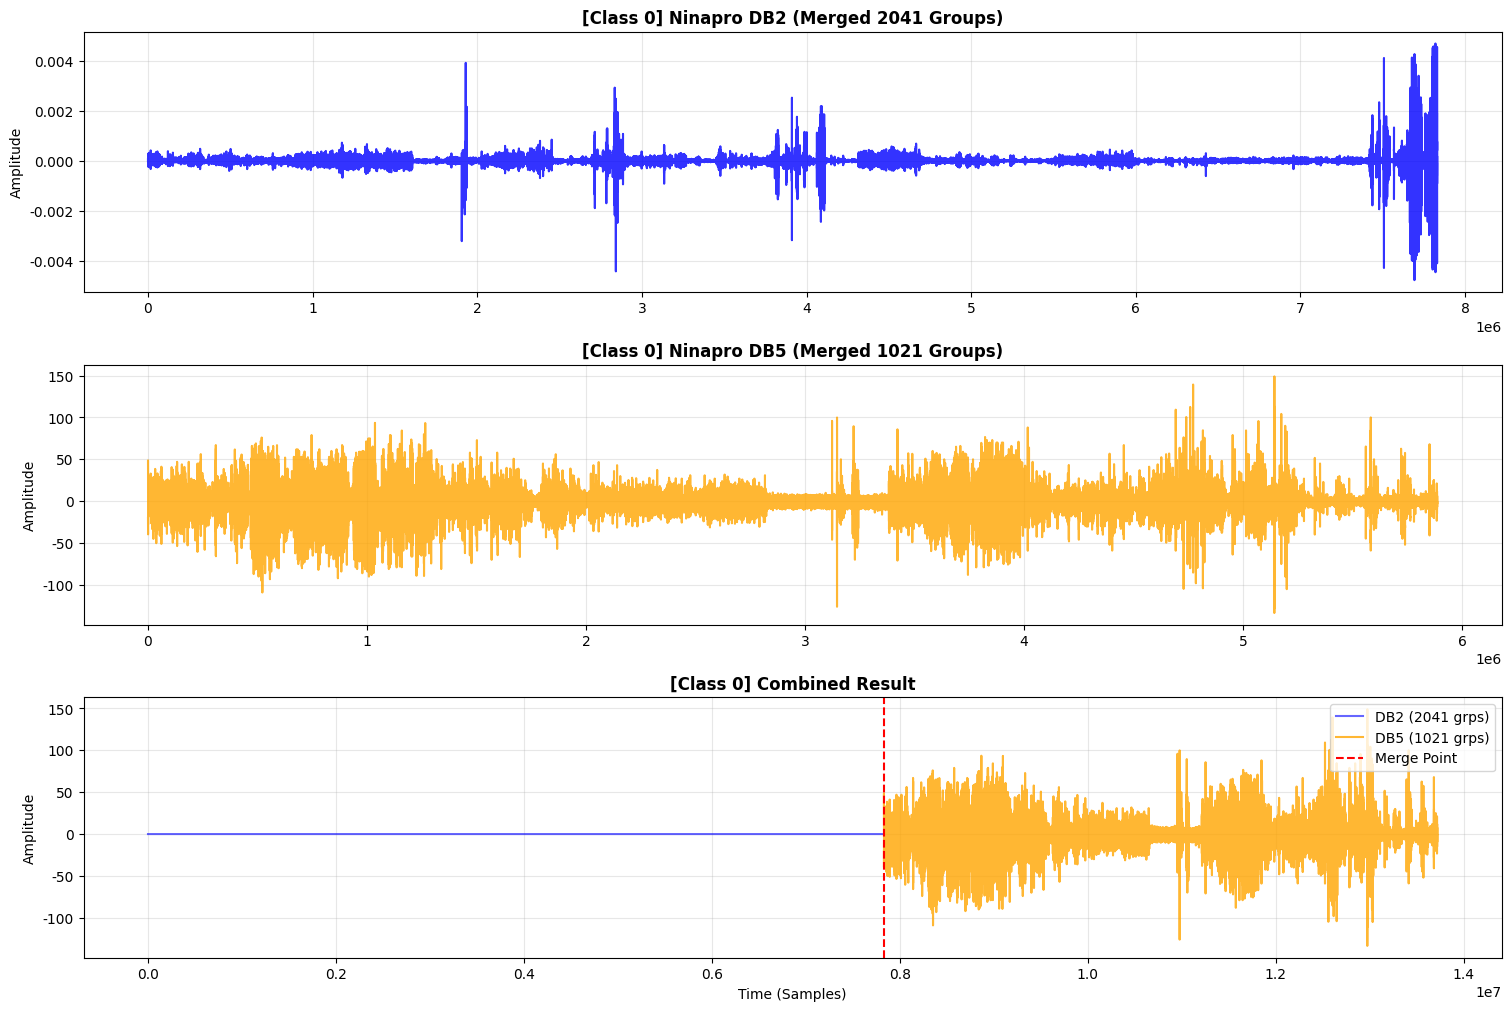

------------------------------------------------------------
Label 1 정보:
  - DB2: 673000 samples (Total 120 Groups merged)
  - DB5: 220000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


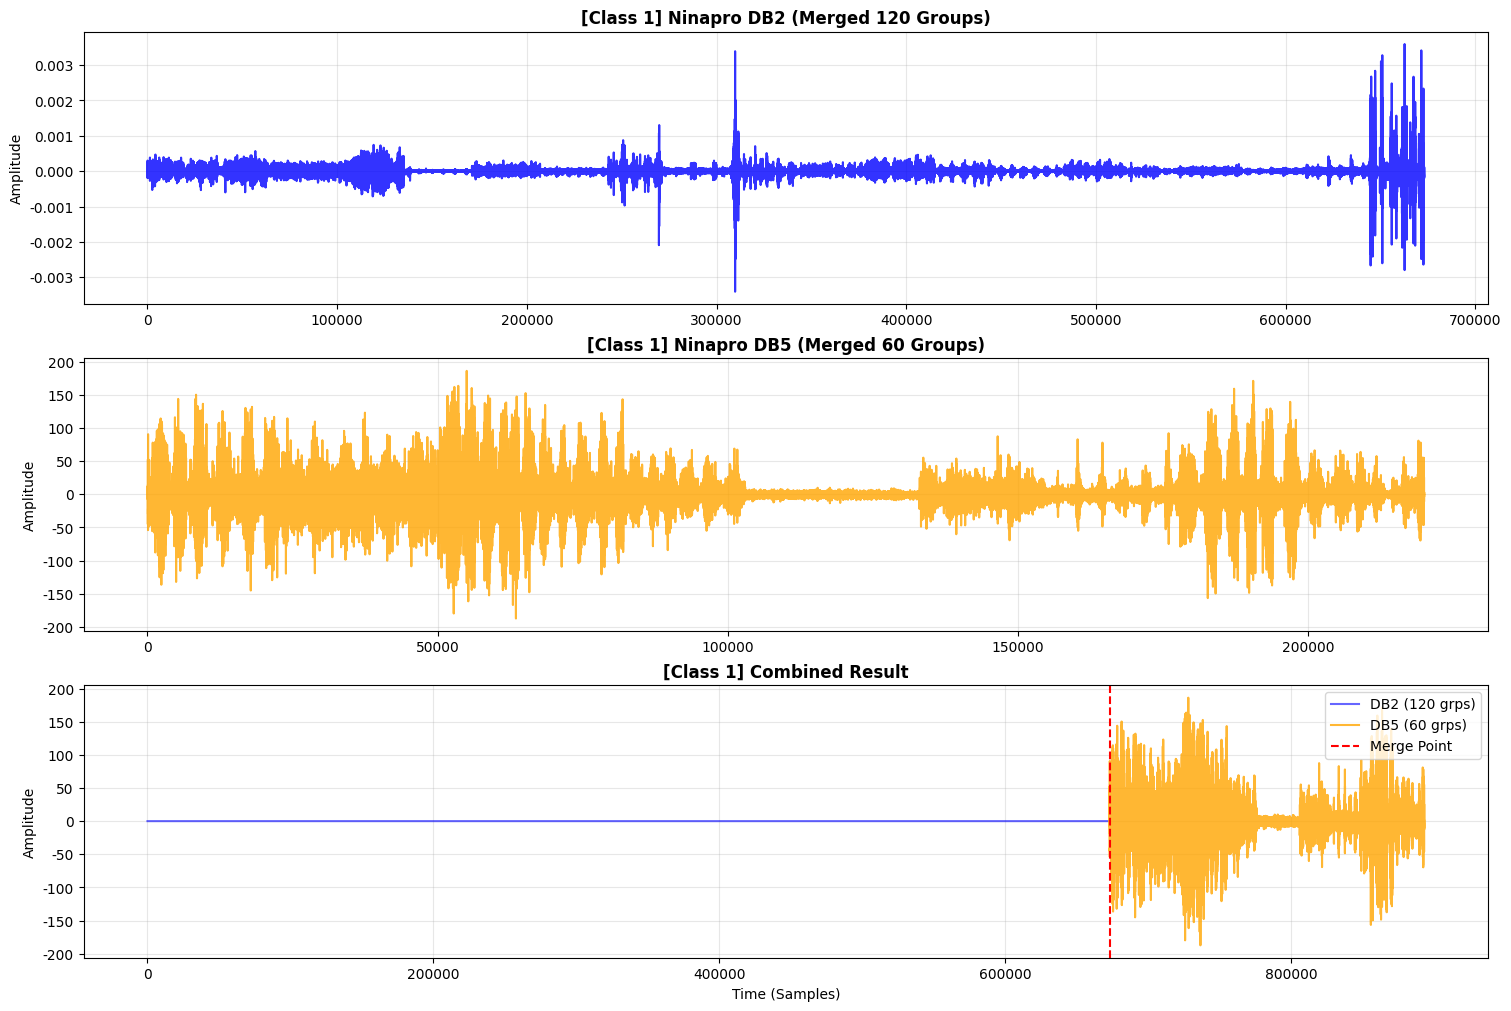

------------------------------------------------------------
Label 2 정보:
  - DB2: 583000 samples (Total 120 Groups merged)
  - DB5: 184000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


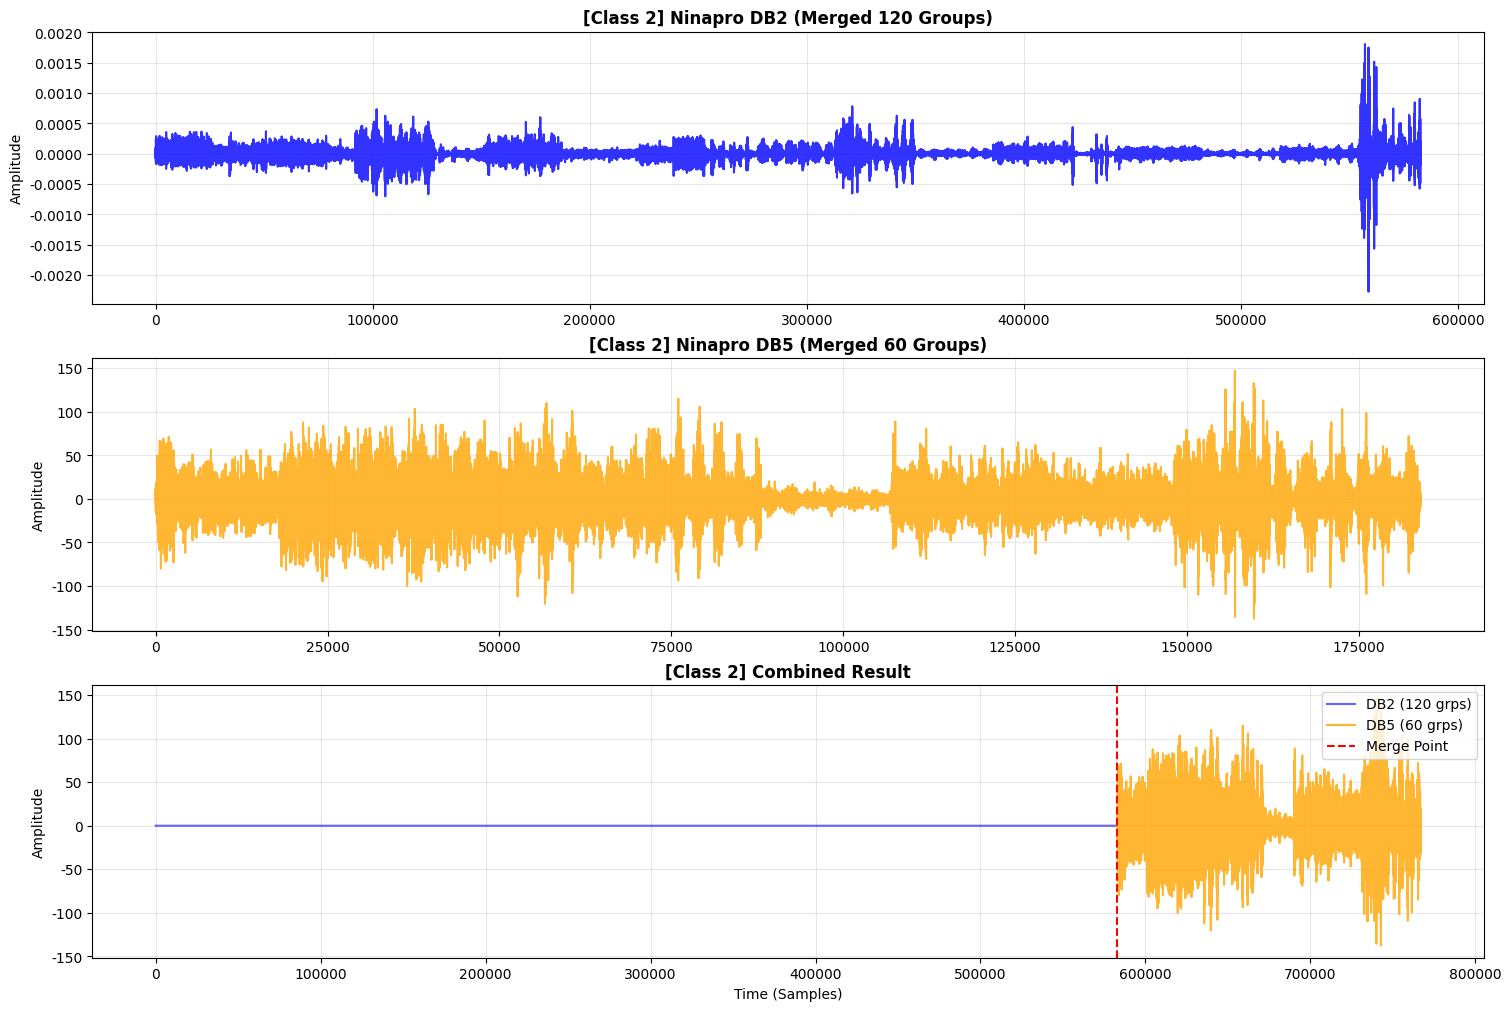

------------------------------------------------------------
Label 3 정보:
  - DB2: 507000 samples (Total 120 Groups merged)
  - DB5: 184000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


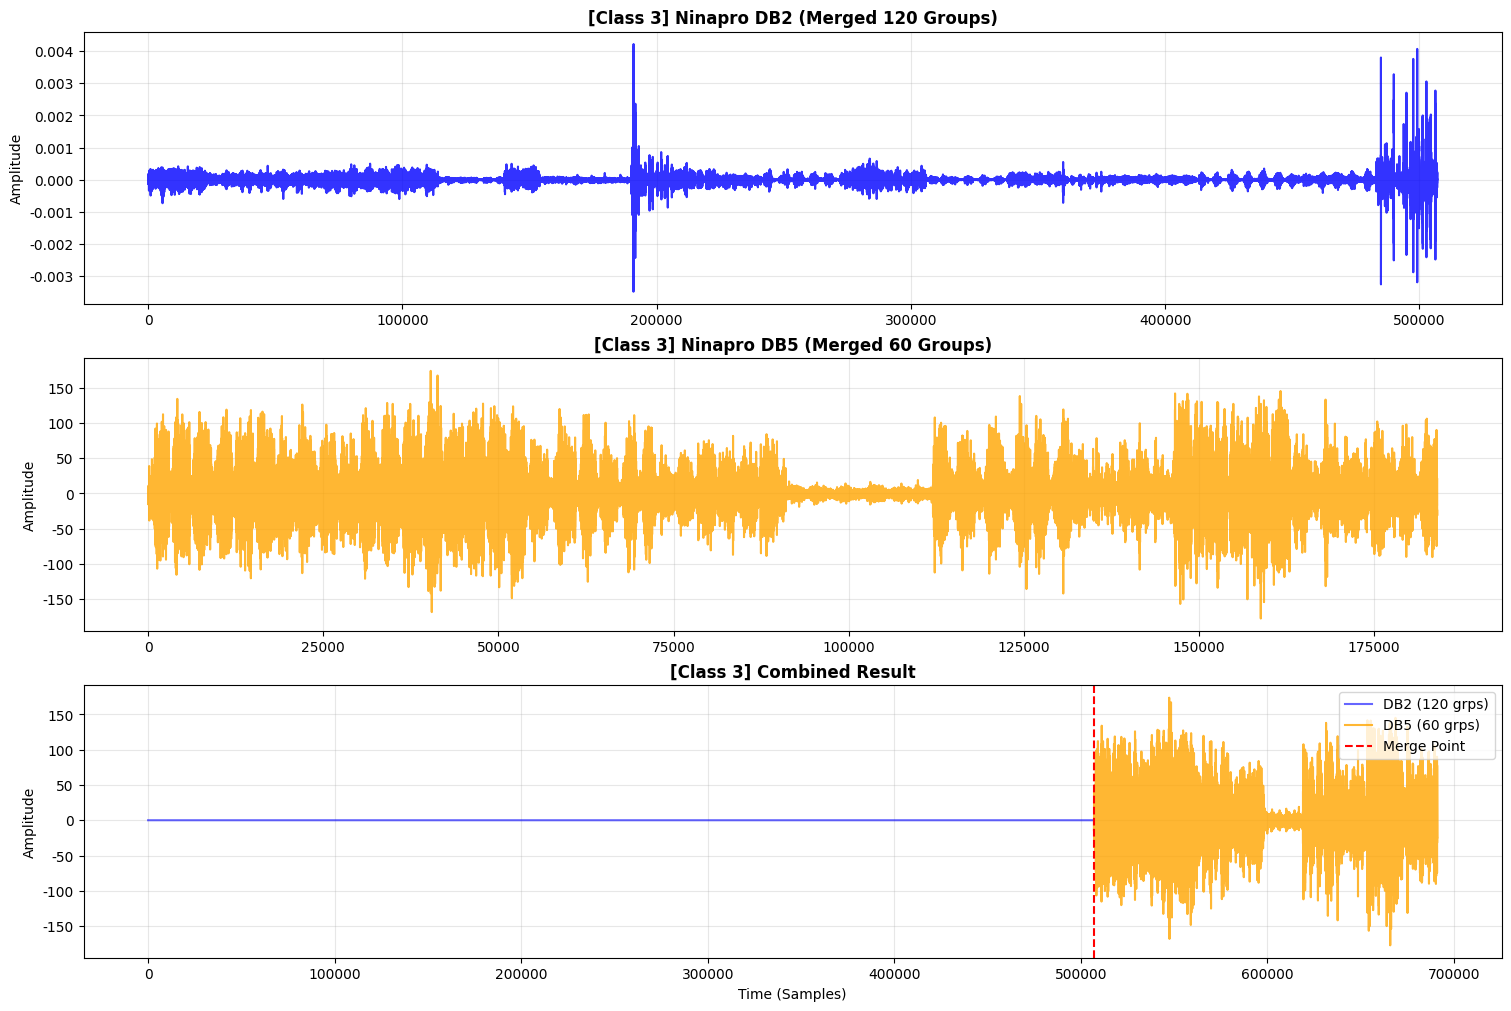

------------------------------------------------------------
Label 4 정보:
  - DB2: 483000 samples (Total 120 Groups merged)
  - DB5: 187000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


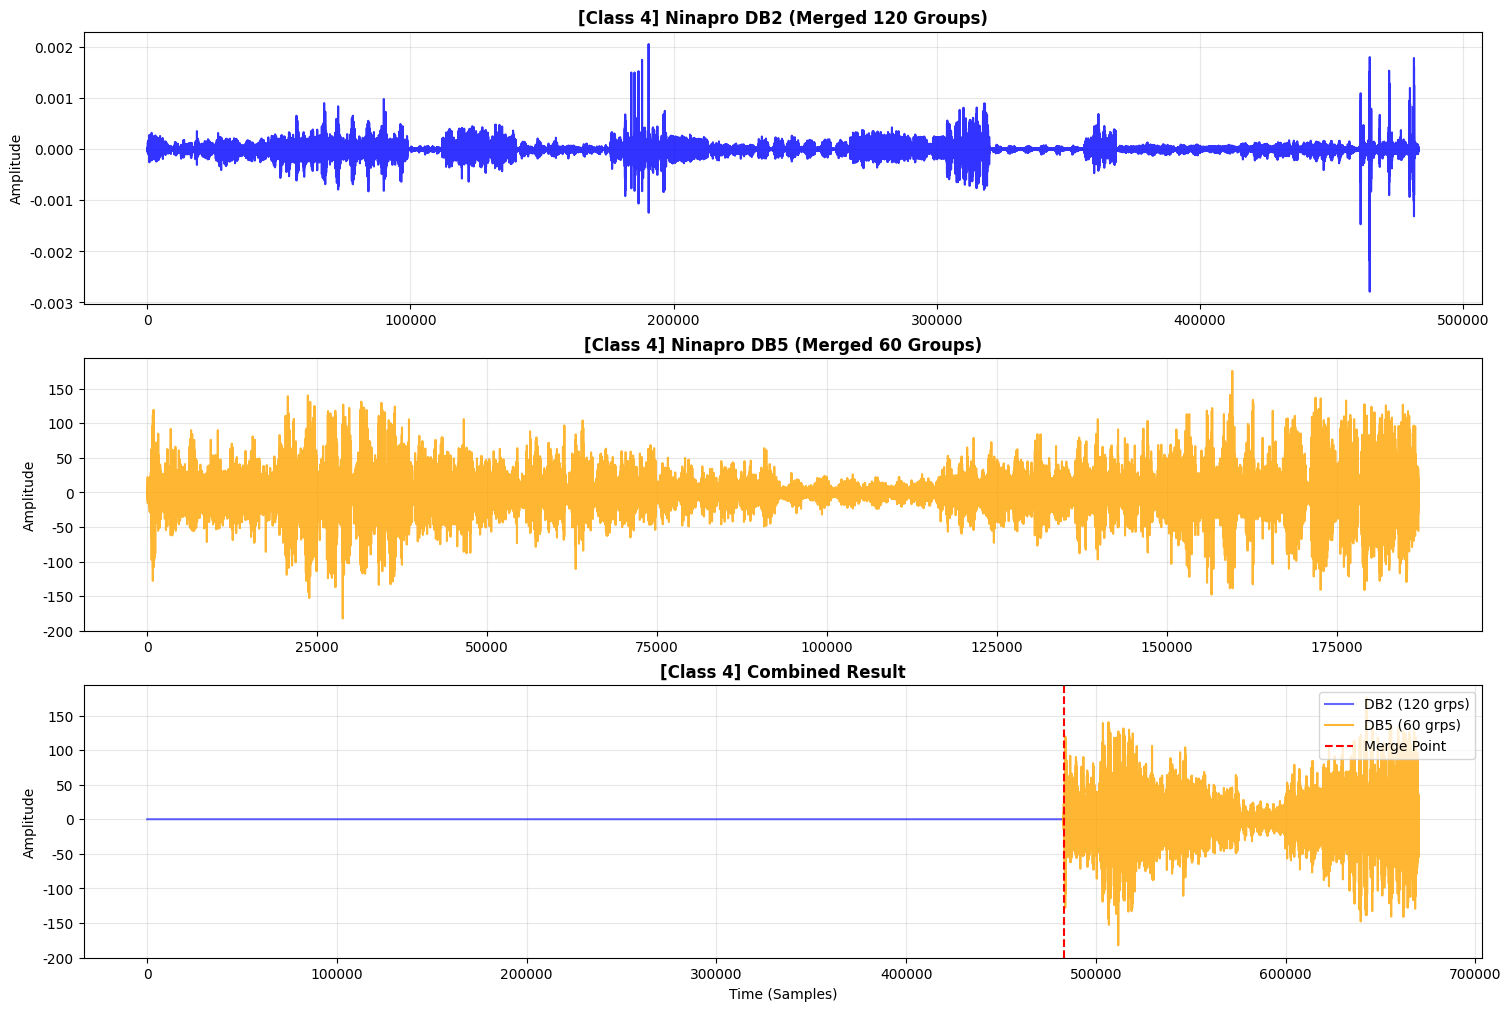

------------------------------------------------------------
Label 5 정보:
  - DB2: 439000 samples (Total 120 Groups merged)
  - DB5: 161000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


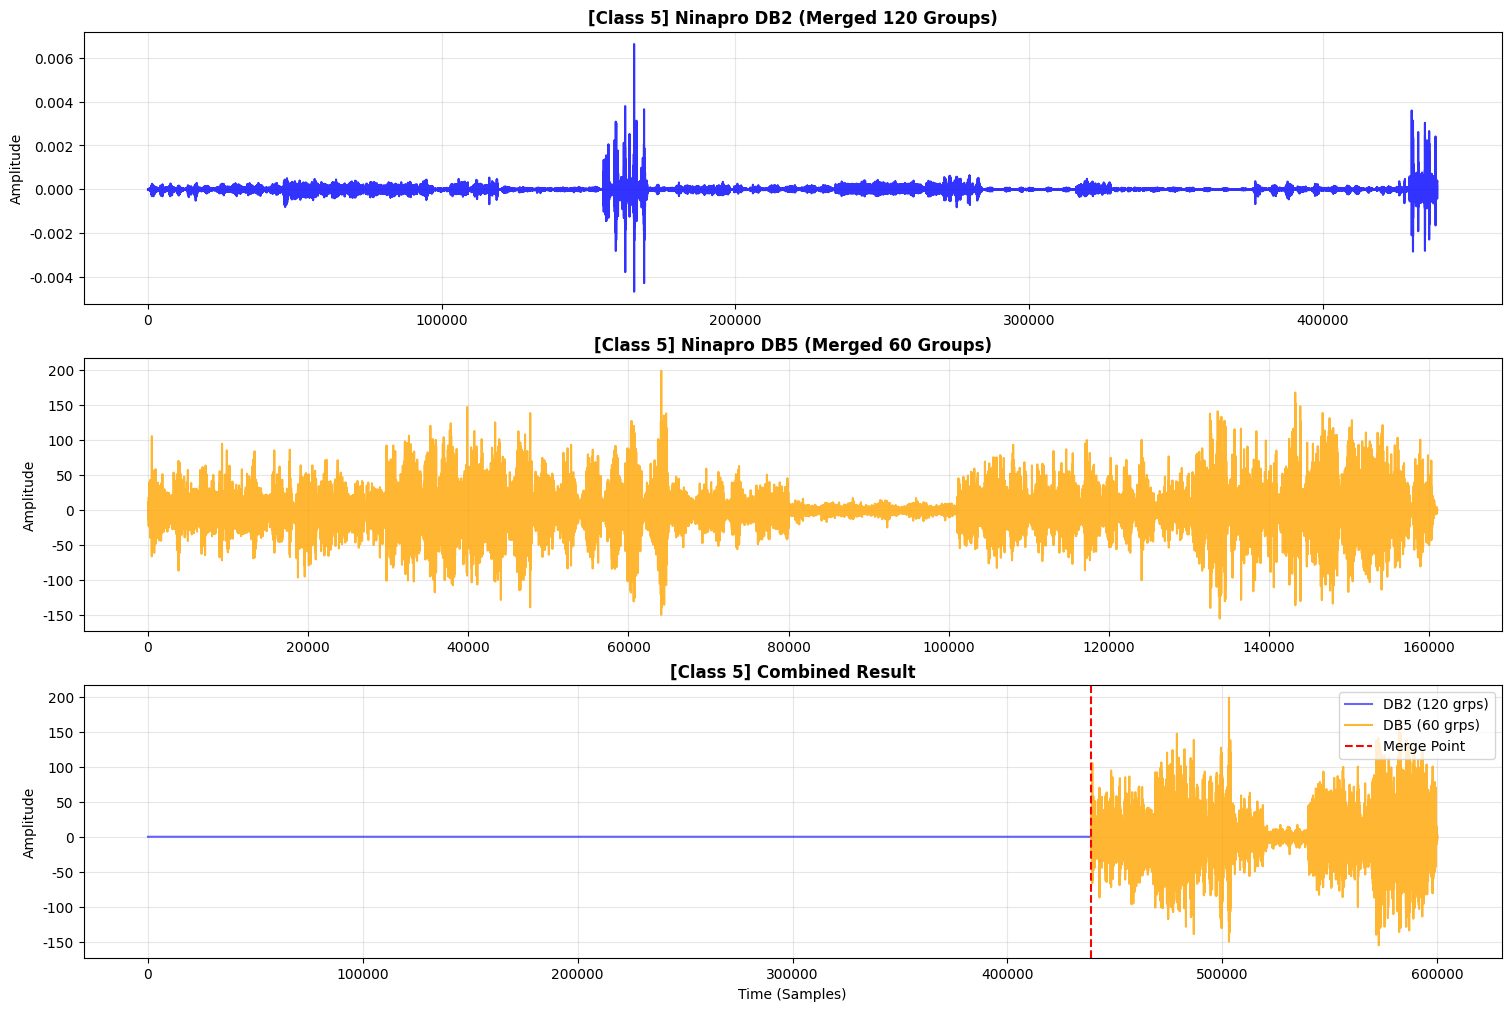

------------------------------------------------------------
Label 6 정보:
  - DB2: 401000 samples (Total 120 Groups merged)
  - DB5: 167000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


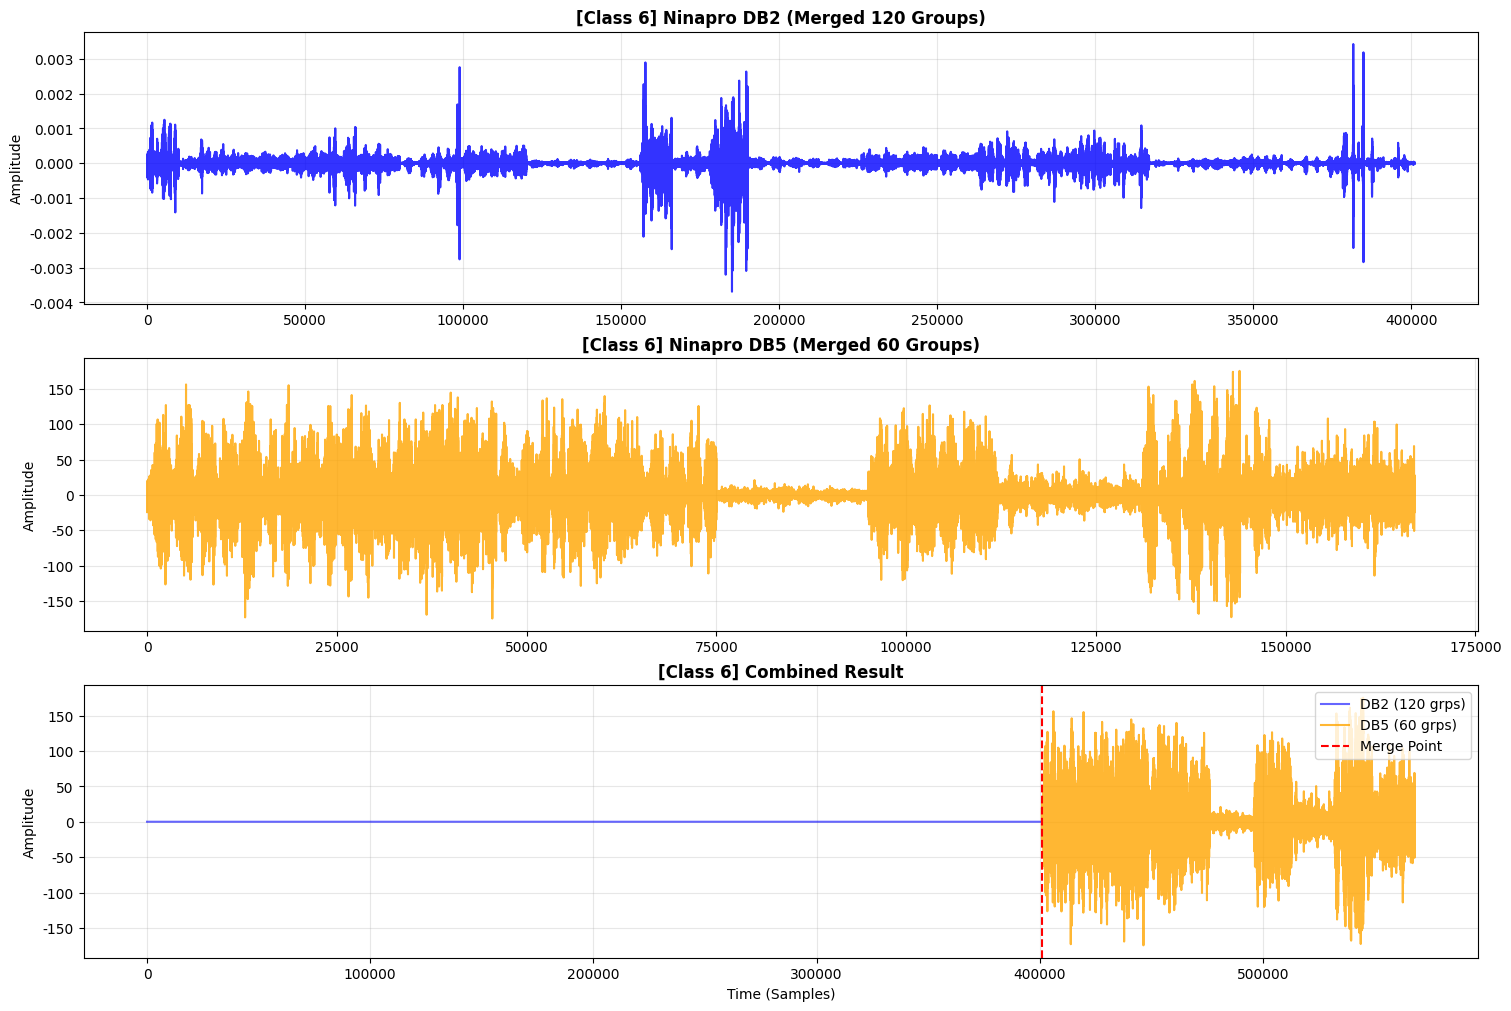

------------------------------------------------------------
Label 7 정보:
  - DB2: 636000 samples (Total 120 Groups merged)
  - DB5: 192000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


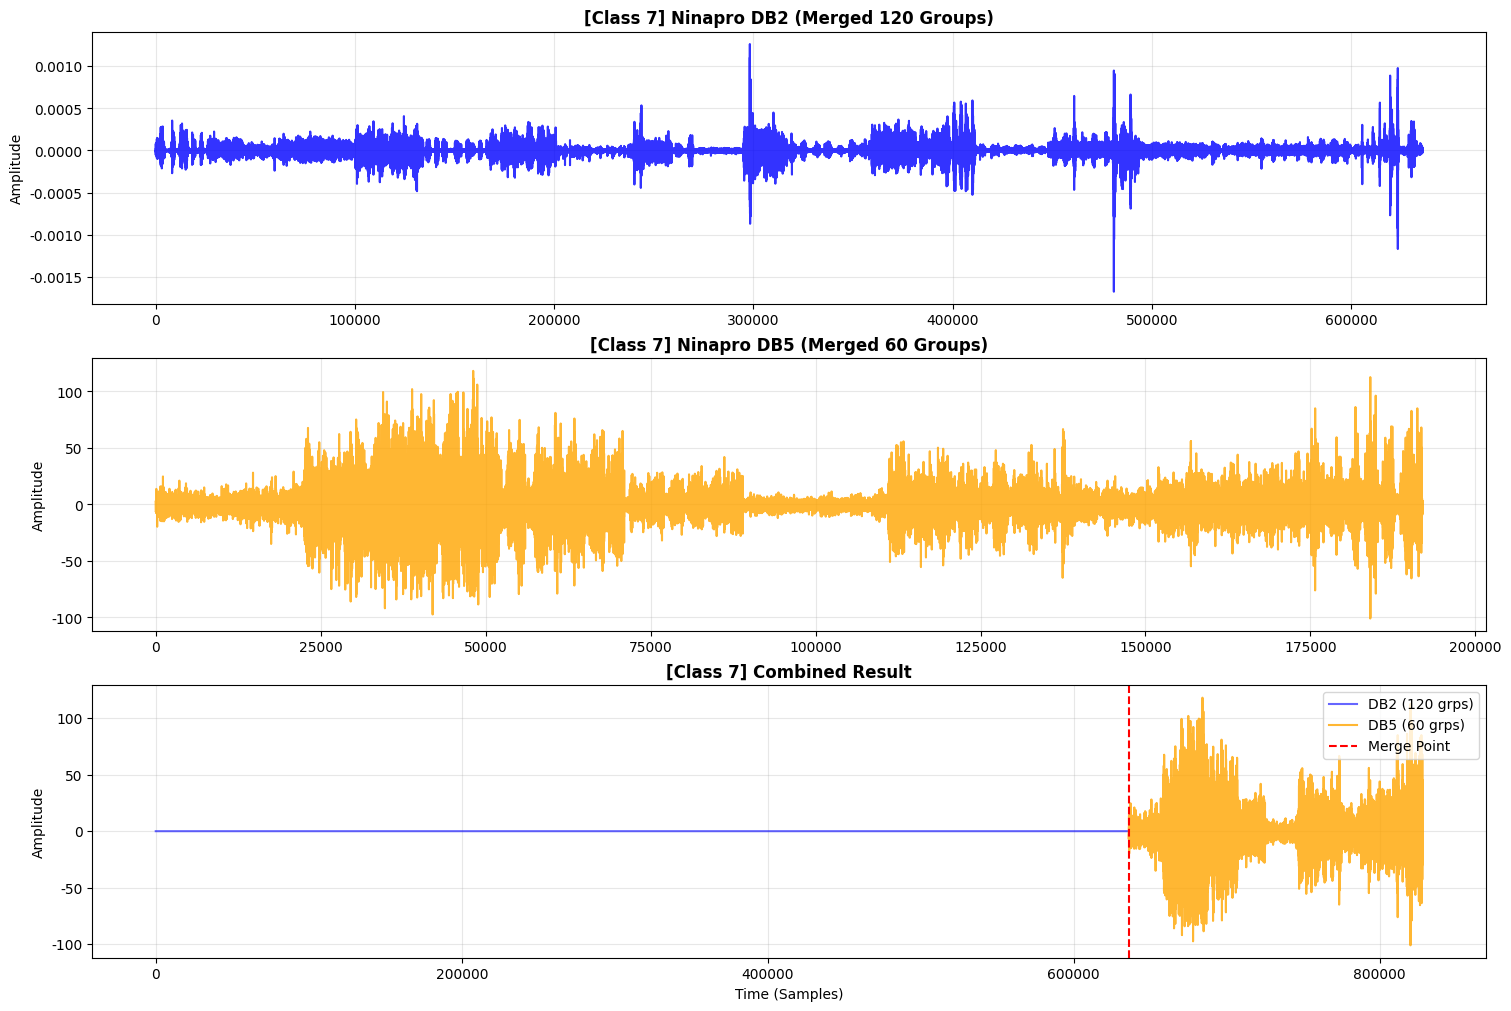

------------------------------------------------------------
Label 8 정보:
  - DB2: 491000 samples (Total 120 Groups merged)
  - DB5: 182000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


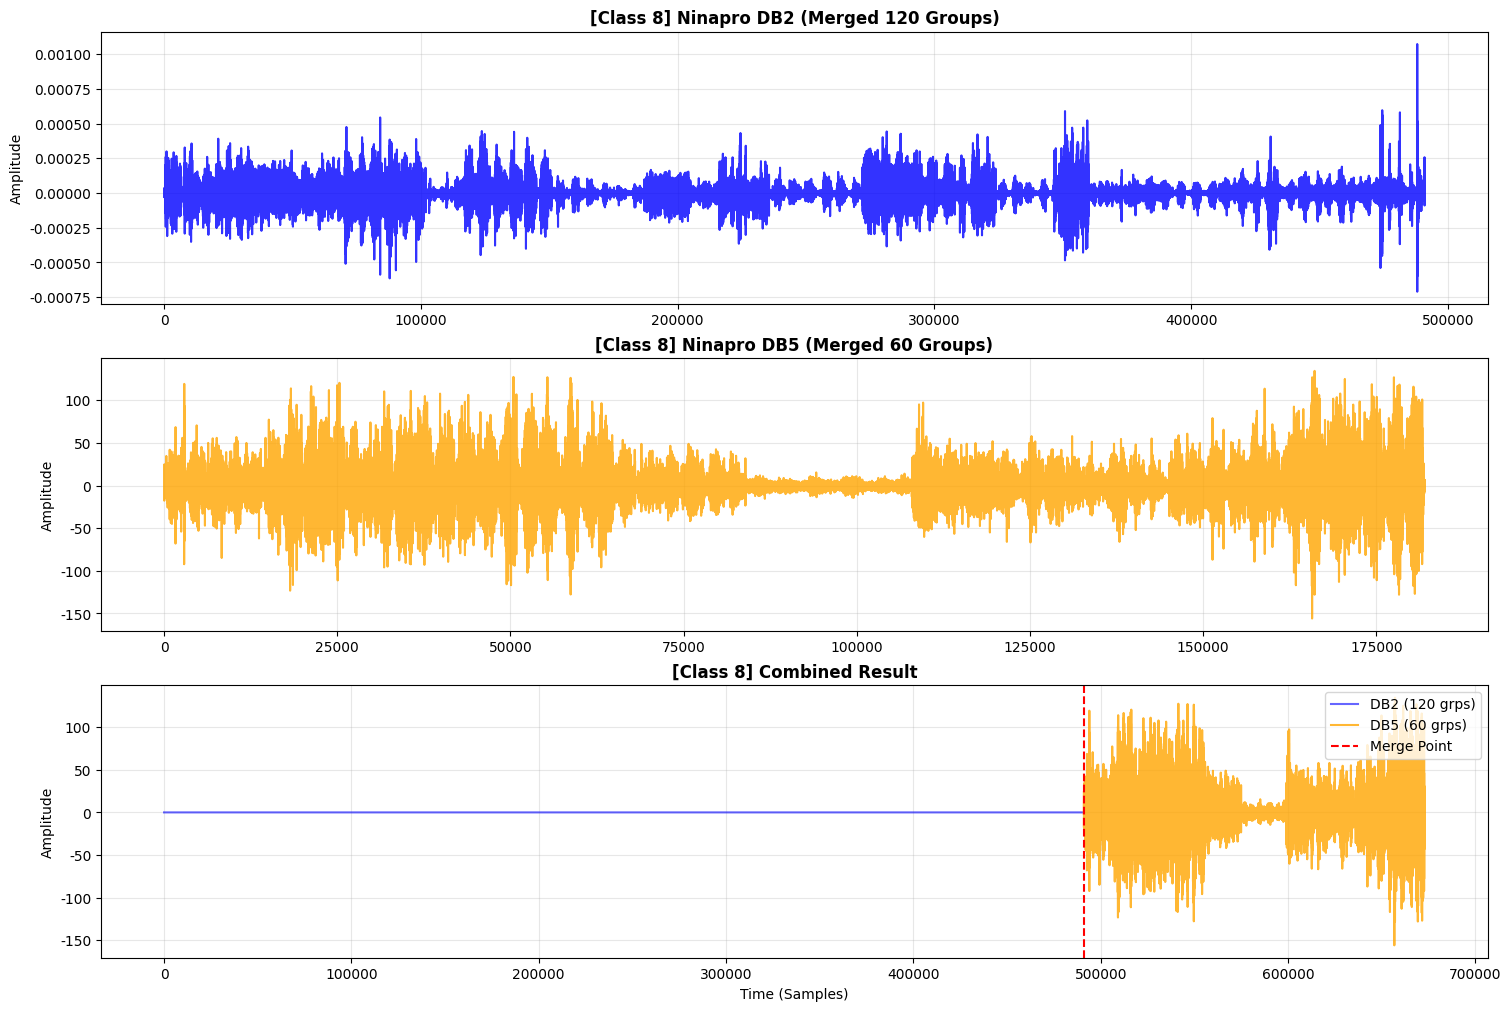

------------------------------------------------------------
Label 9 정보:
  - DB2: 532000 samples (Total 120 Groups merged)
  - DB5: 199000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


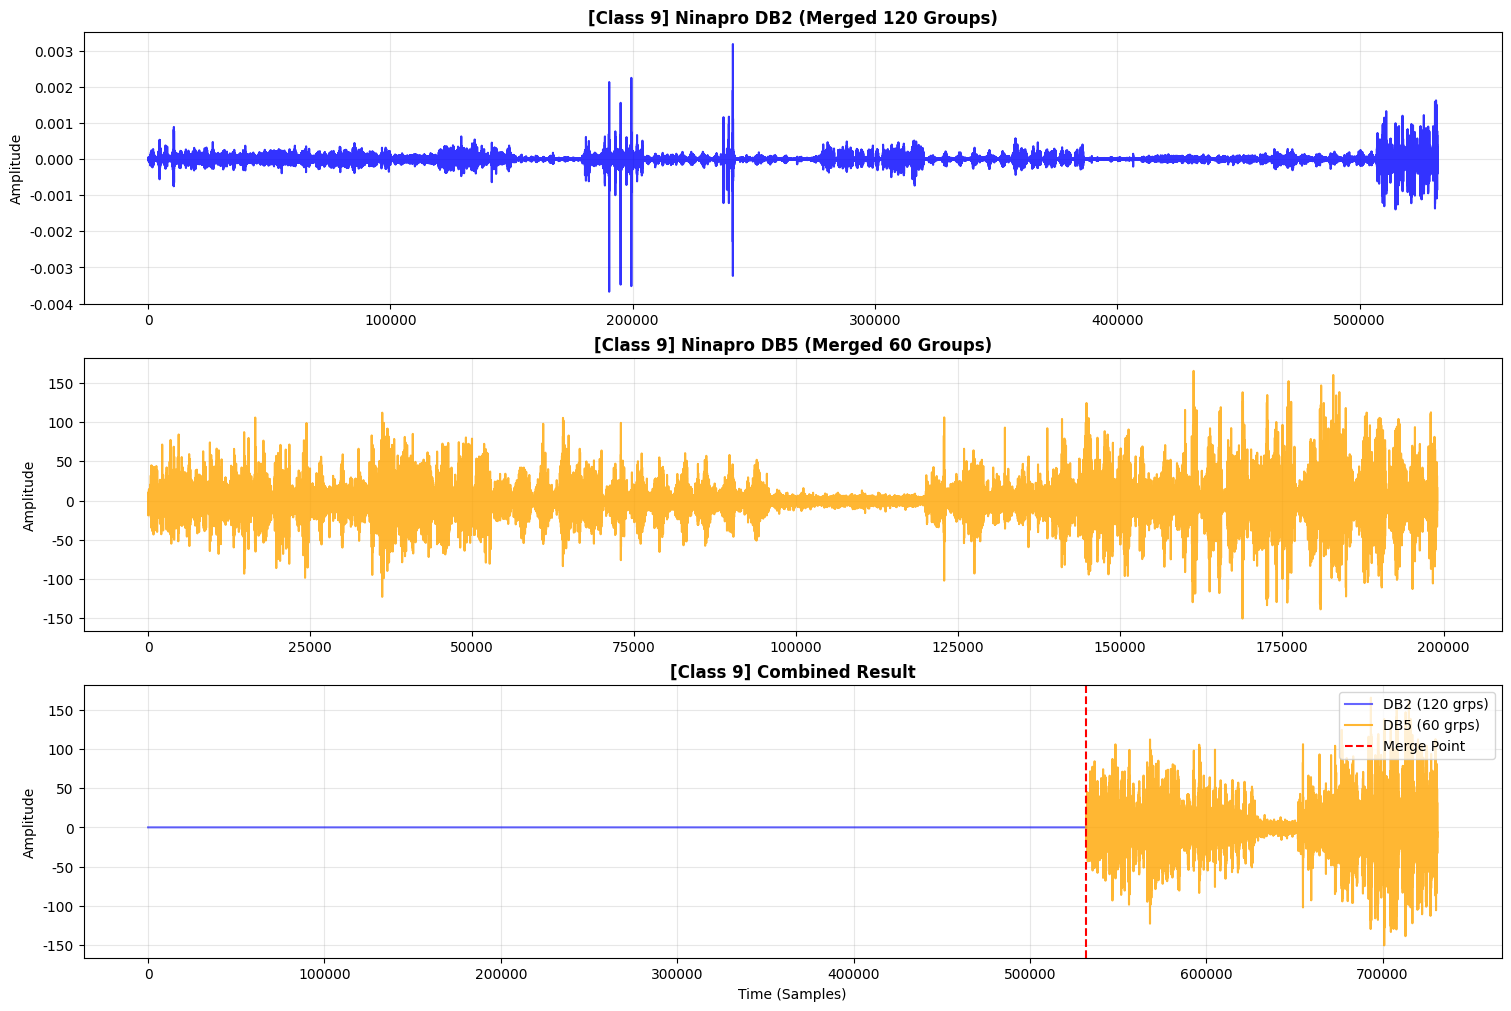

------------------------------------------------------------
Label 10 정보:
  - DB2: 516000 samples (Total 120 Groups merged)
  - DB5: 187000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


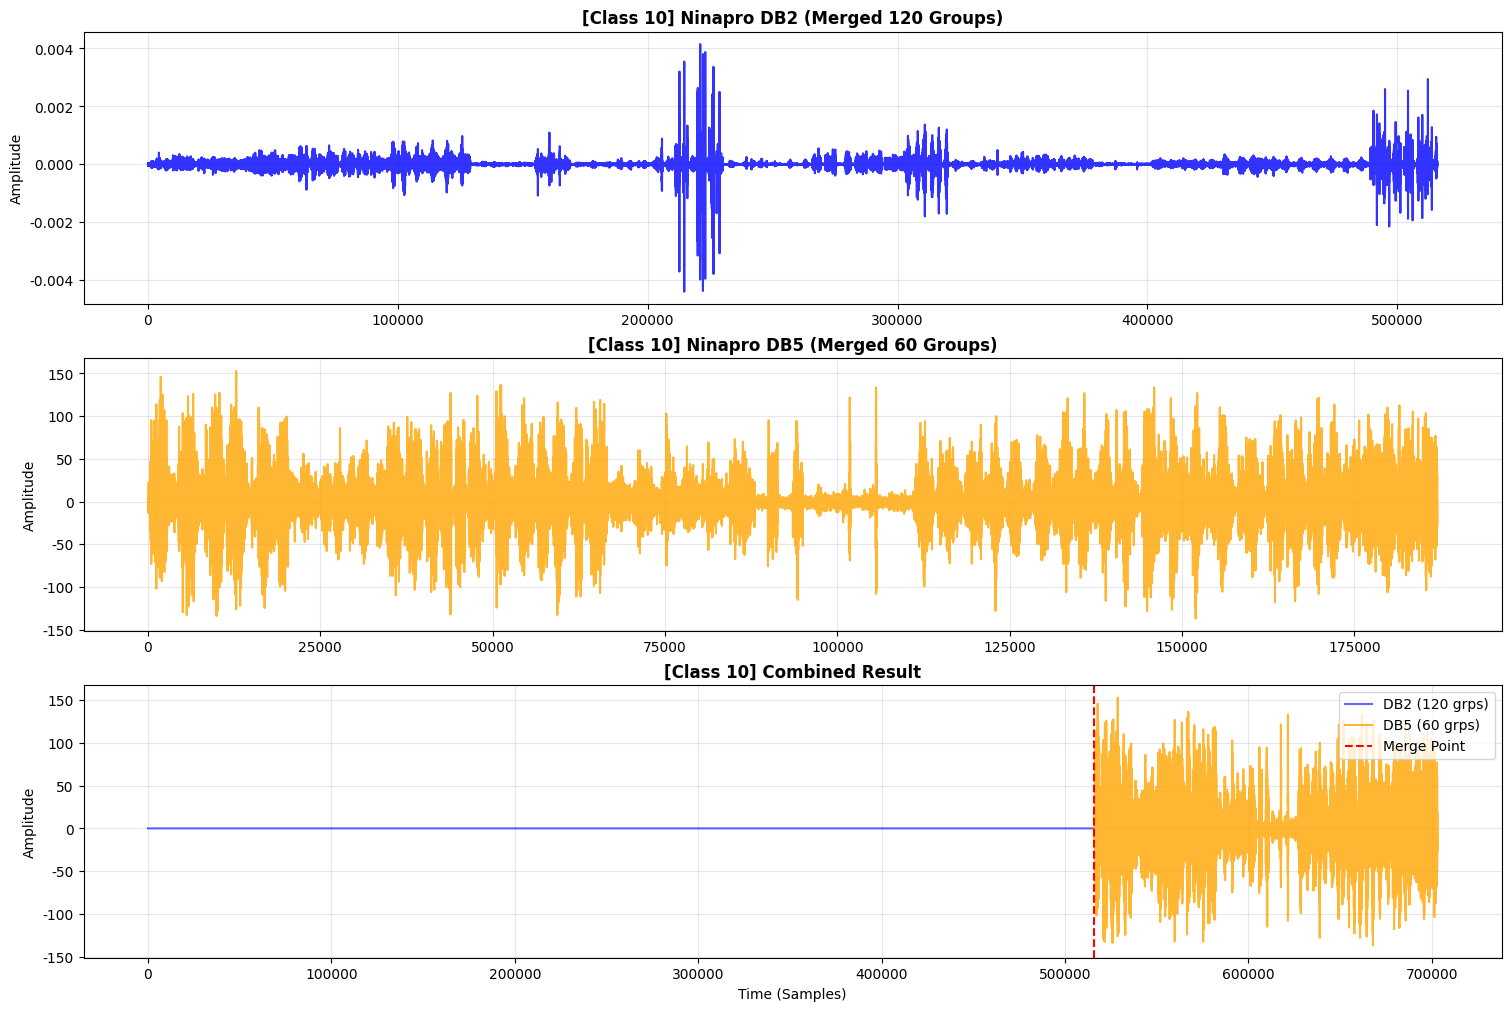

------------------------------------------------------------
Label 11 정보:
  - DB2: 549000 samples (Total 120 Groups merged)
  - DB5: 218000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


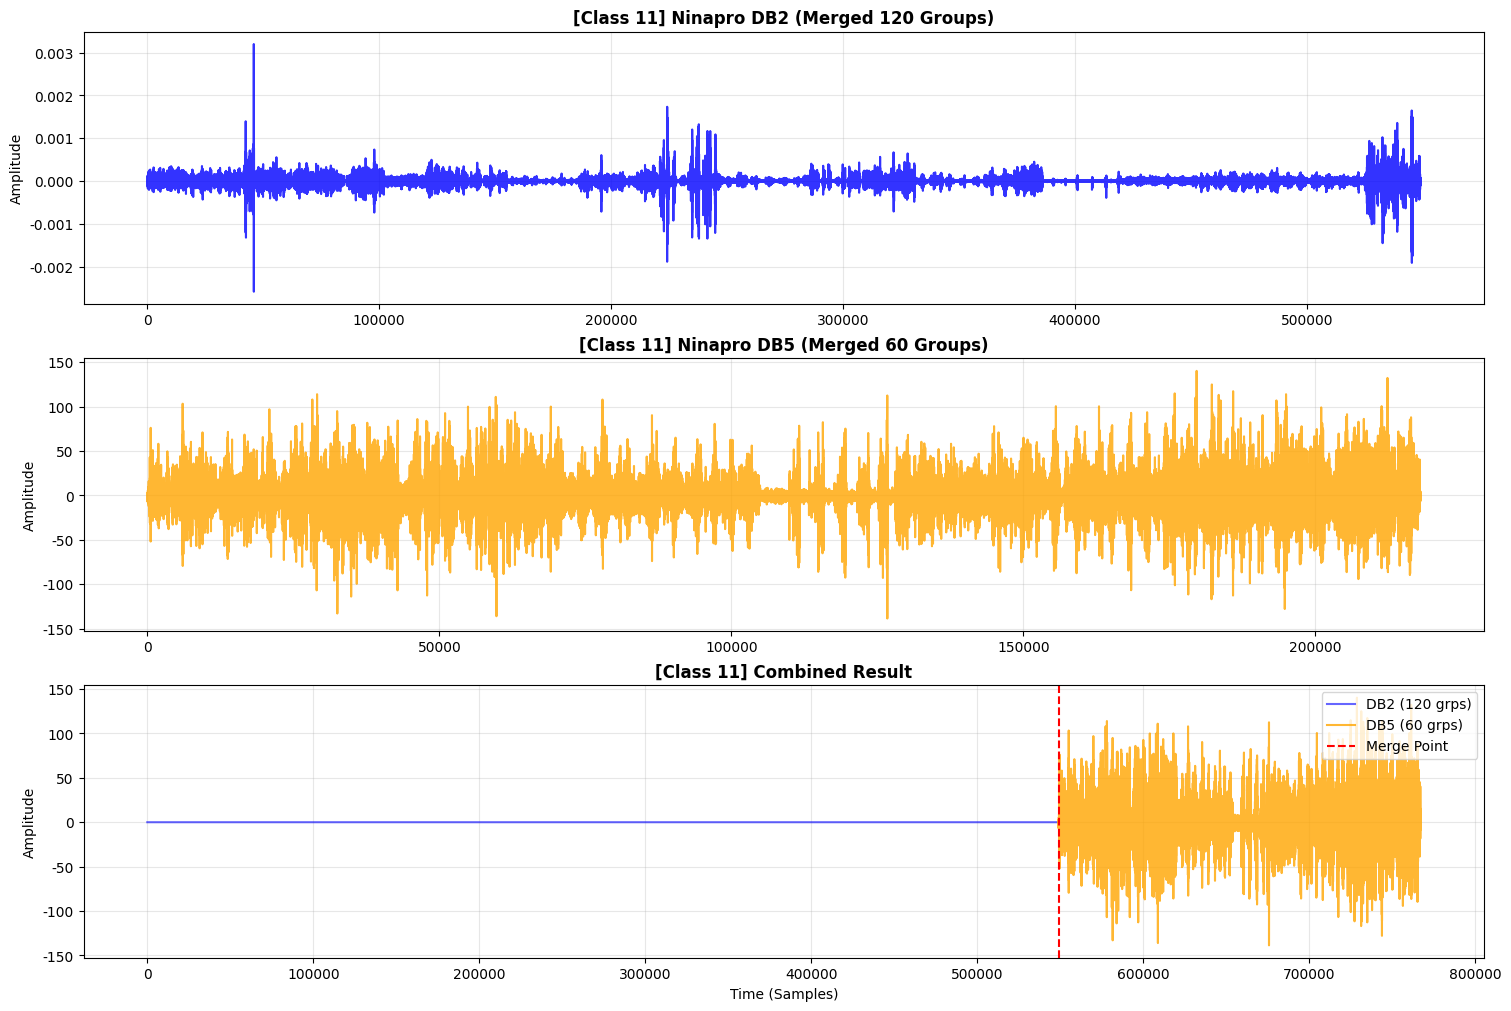

------------------------------------------------------------
Label 12 정보:
  - DB2: 446000 samples (Total 120 Groups merged)
  - DB5: 195000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


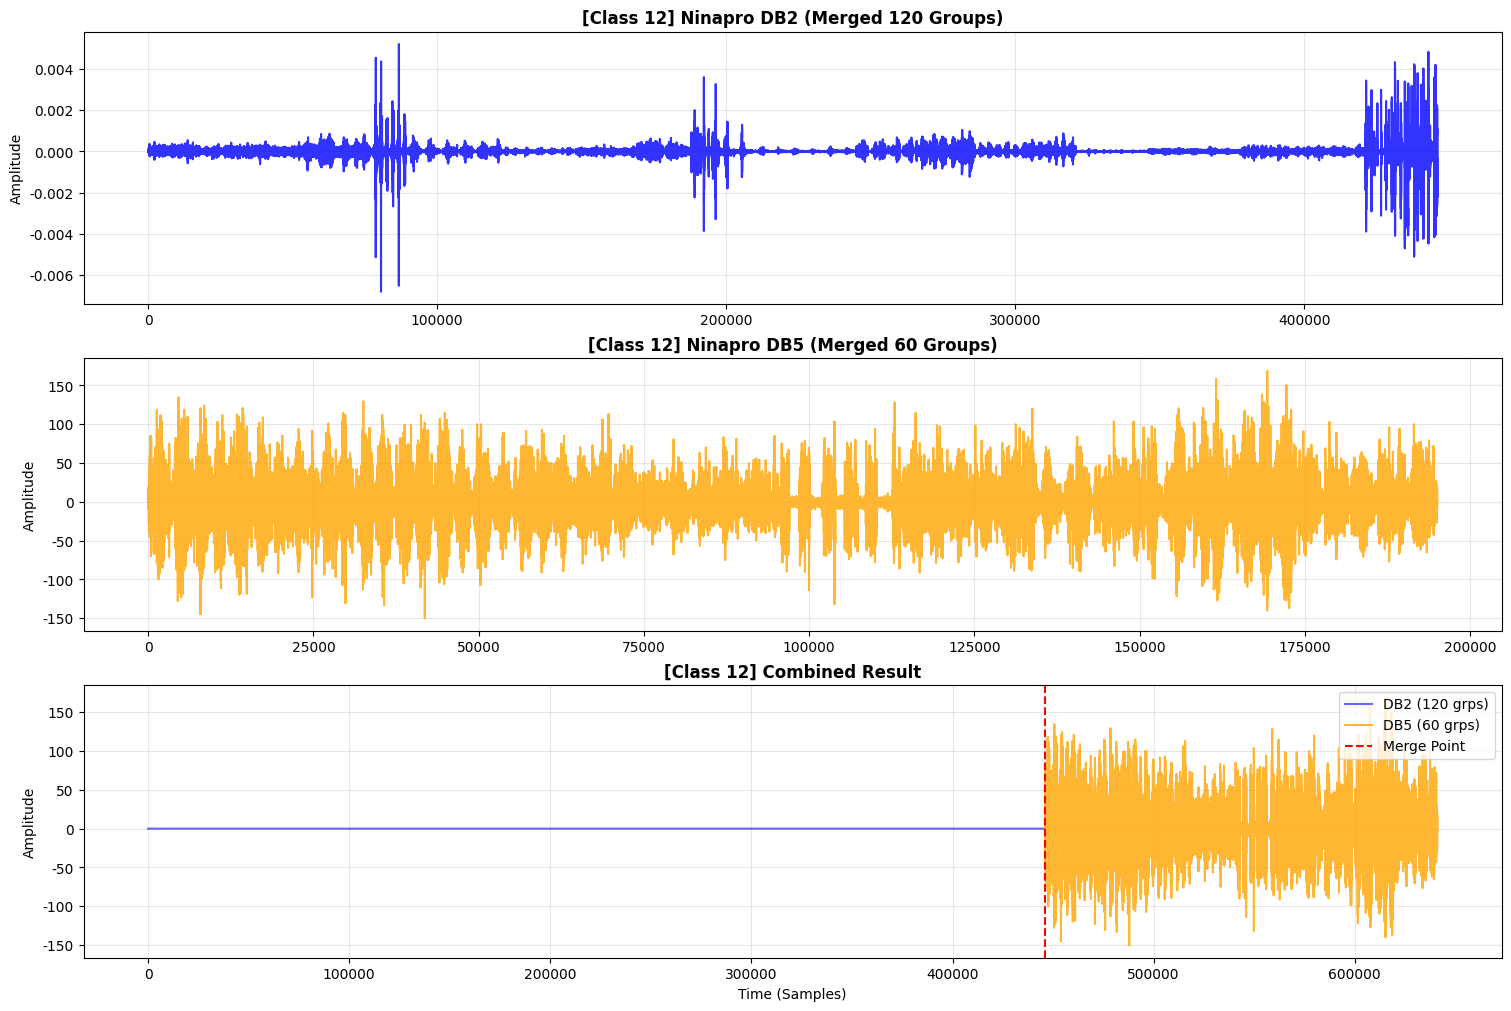

------------------------------------------------------------
Label 13 정보:
  - DB2: 352000 samples (Total 120 Groups merged)
  - DB5: 194000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


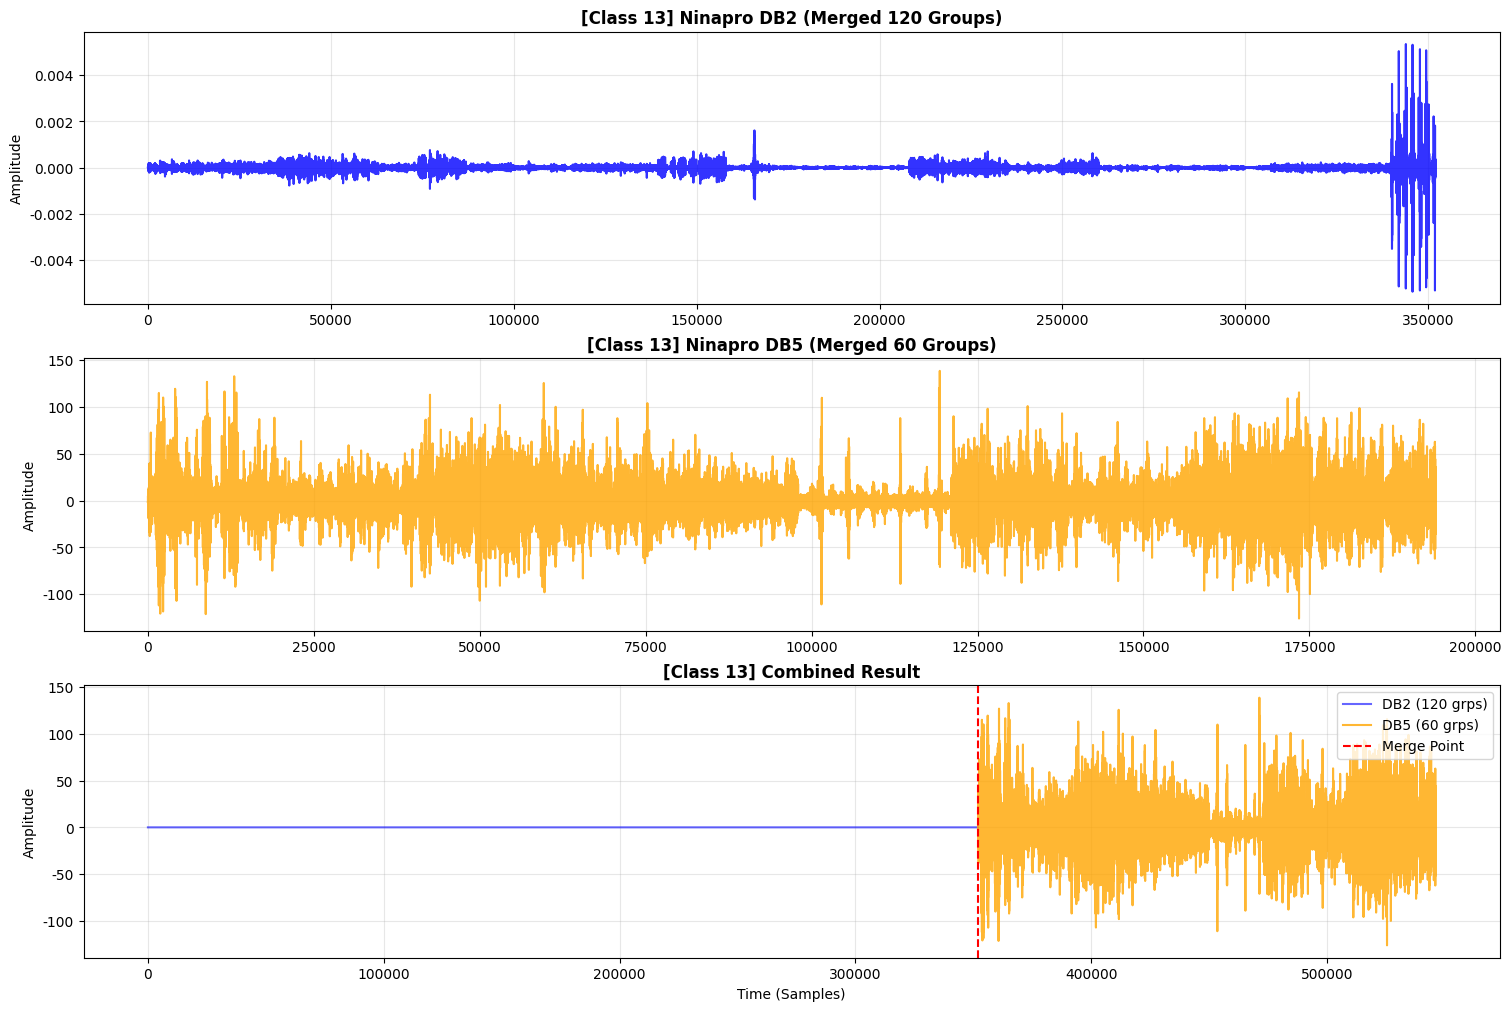

------------------------------------------------------------
Label 14 정보:
  - DB2: 354000 samples (Total 120 Groups merged)
  - DB5: 168000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


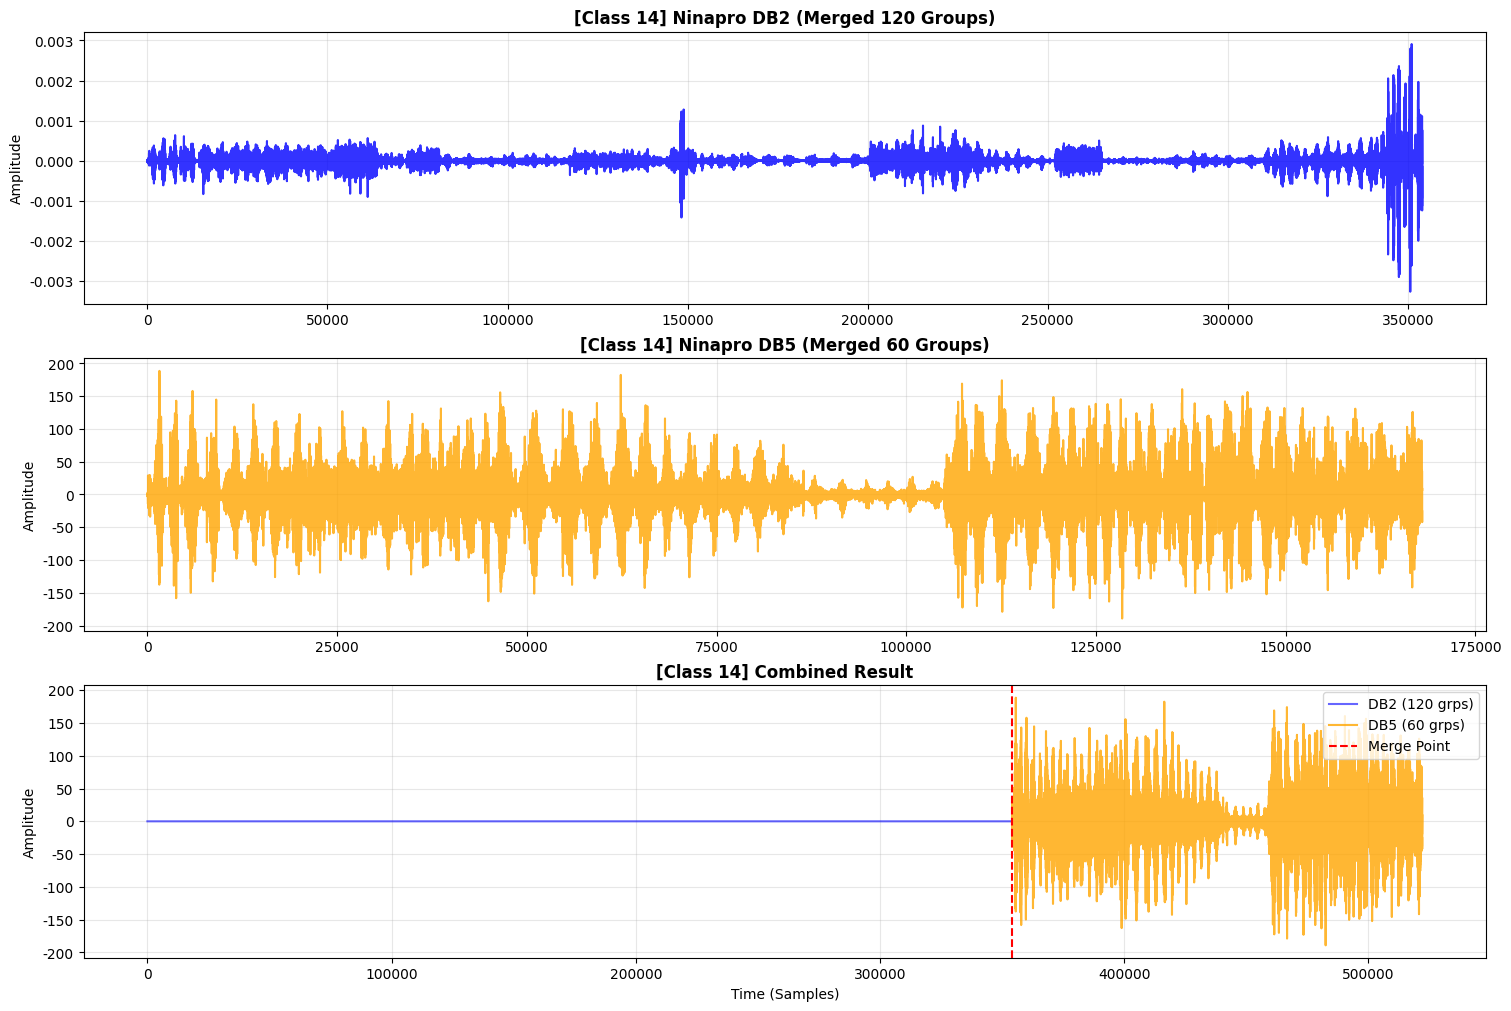

------------------------------------------------------------
Label 15 정보:
  - DB2: 458000 samples (Total 120 Groups merged)
  - DB5: 151000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


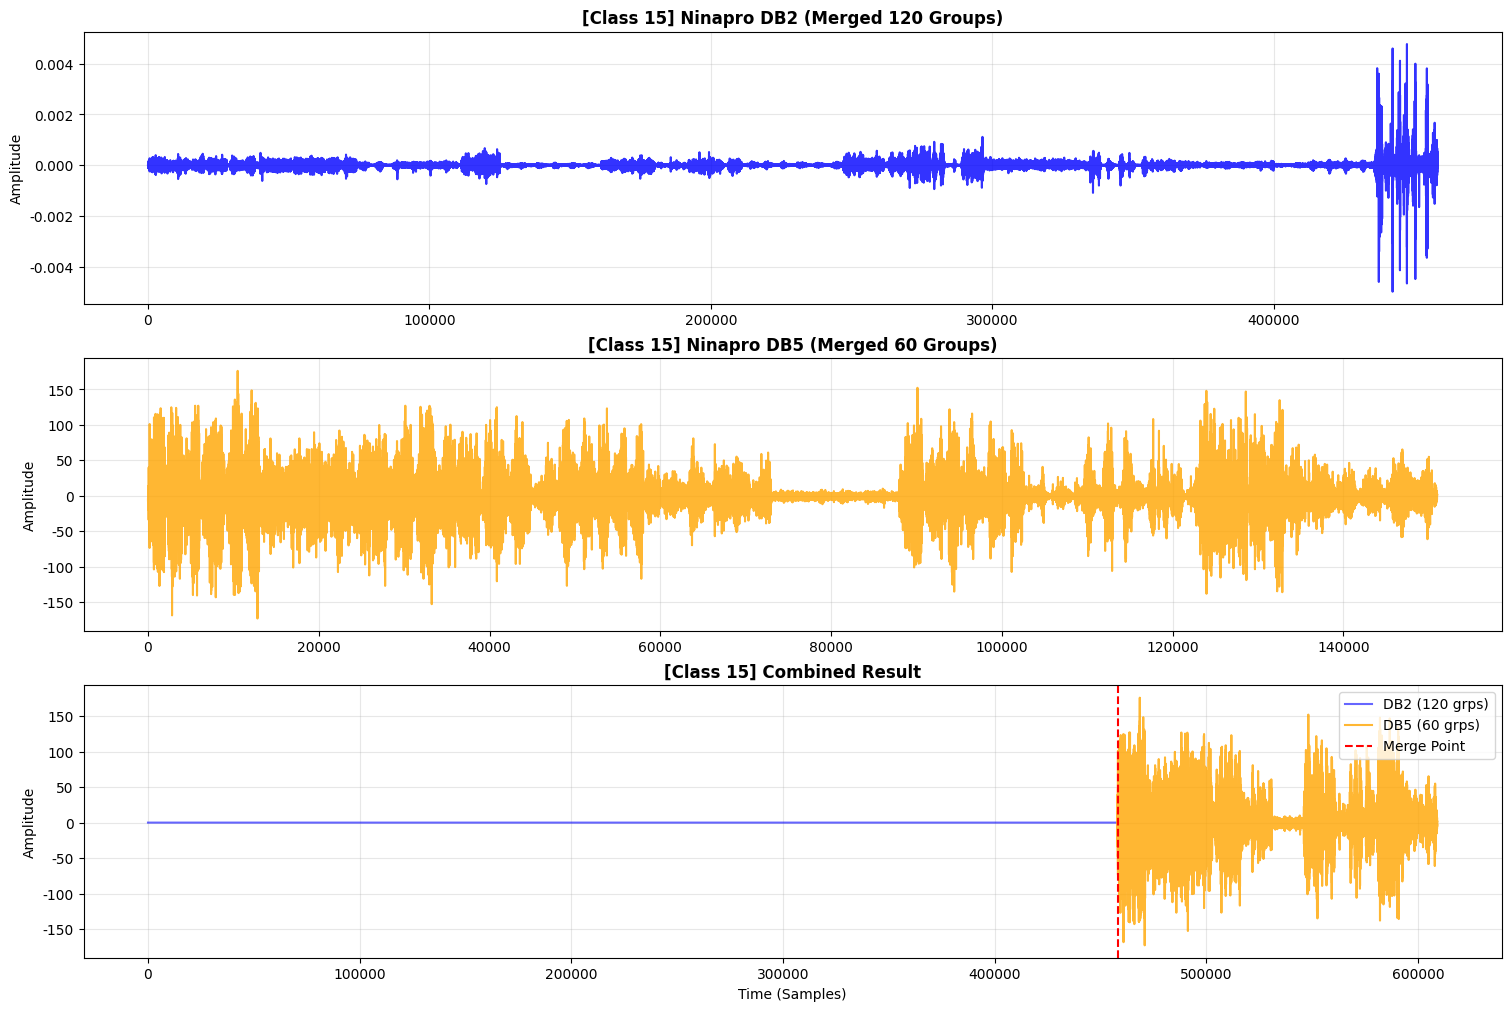

------------------------------------------------------------
Label 16 정보:
  - DB2: 451000 samples (Total 120 Groups merged)
  - DB5: 224000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


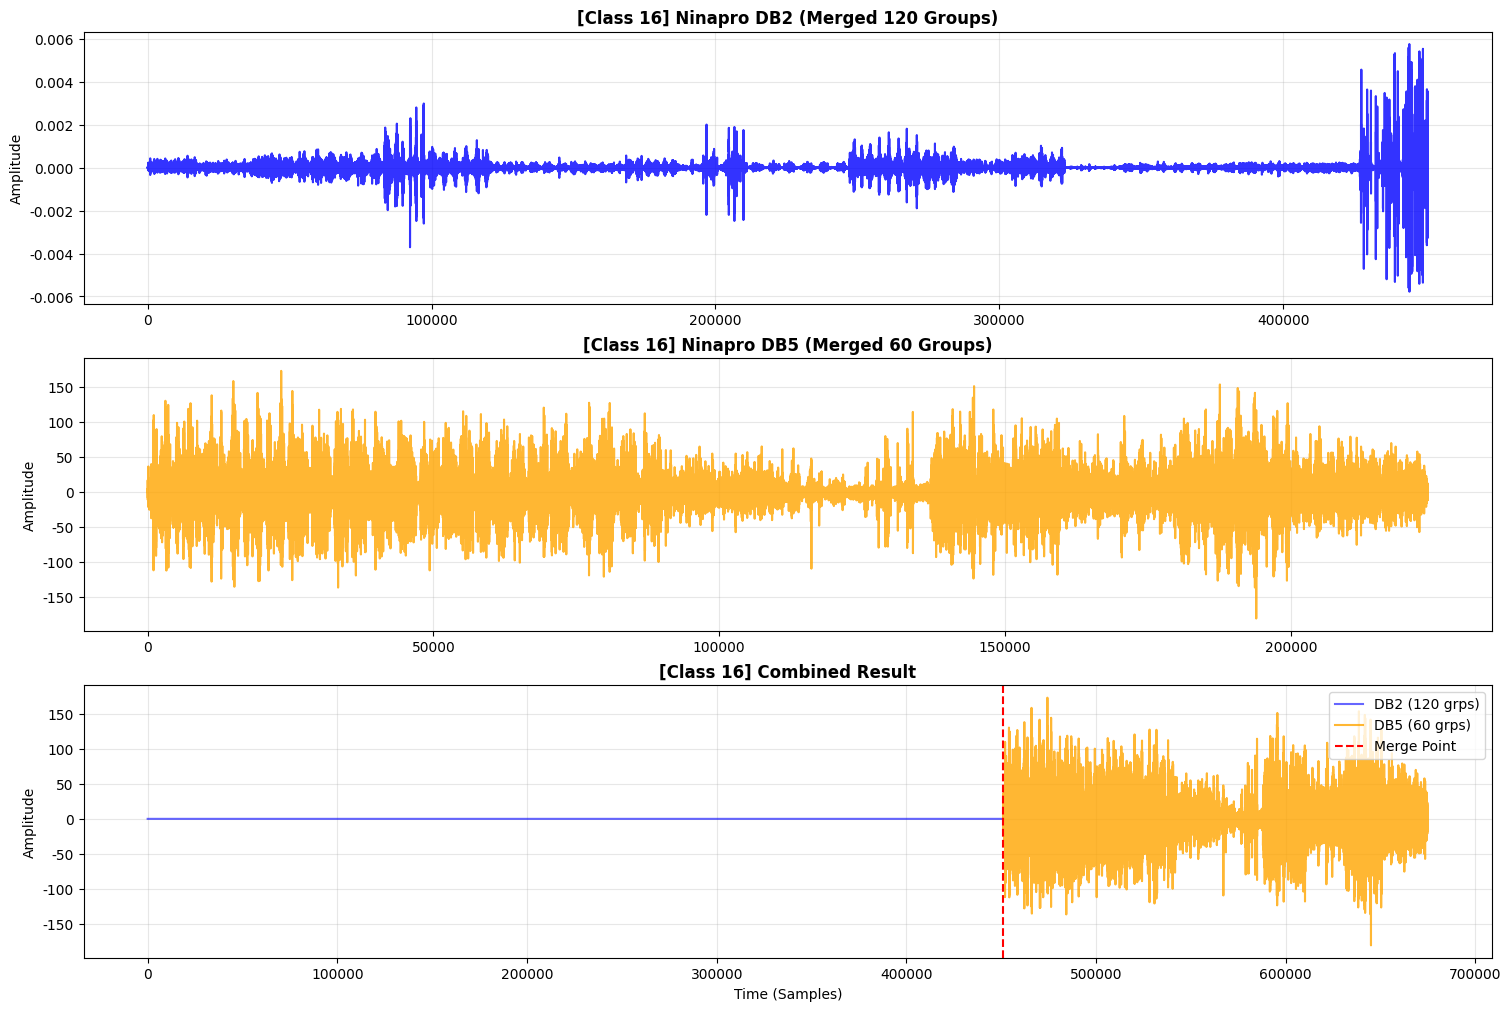

------------------------------------------------------------
Label 17 정보:
  - DB2: 359000 samples (Total 120 Groups merged)
  - DB5: 203000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


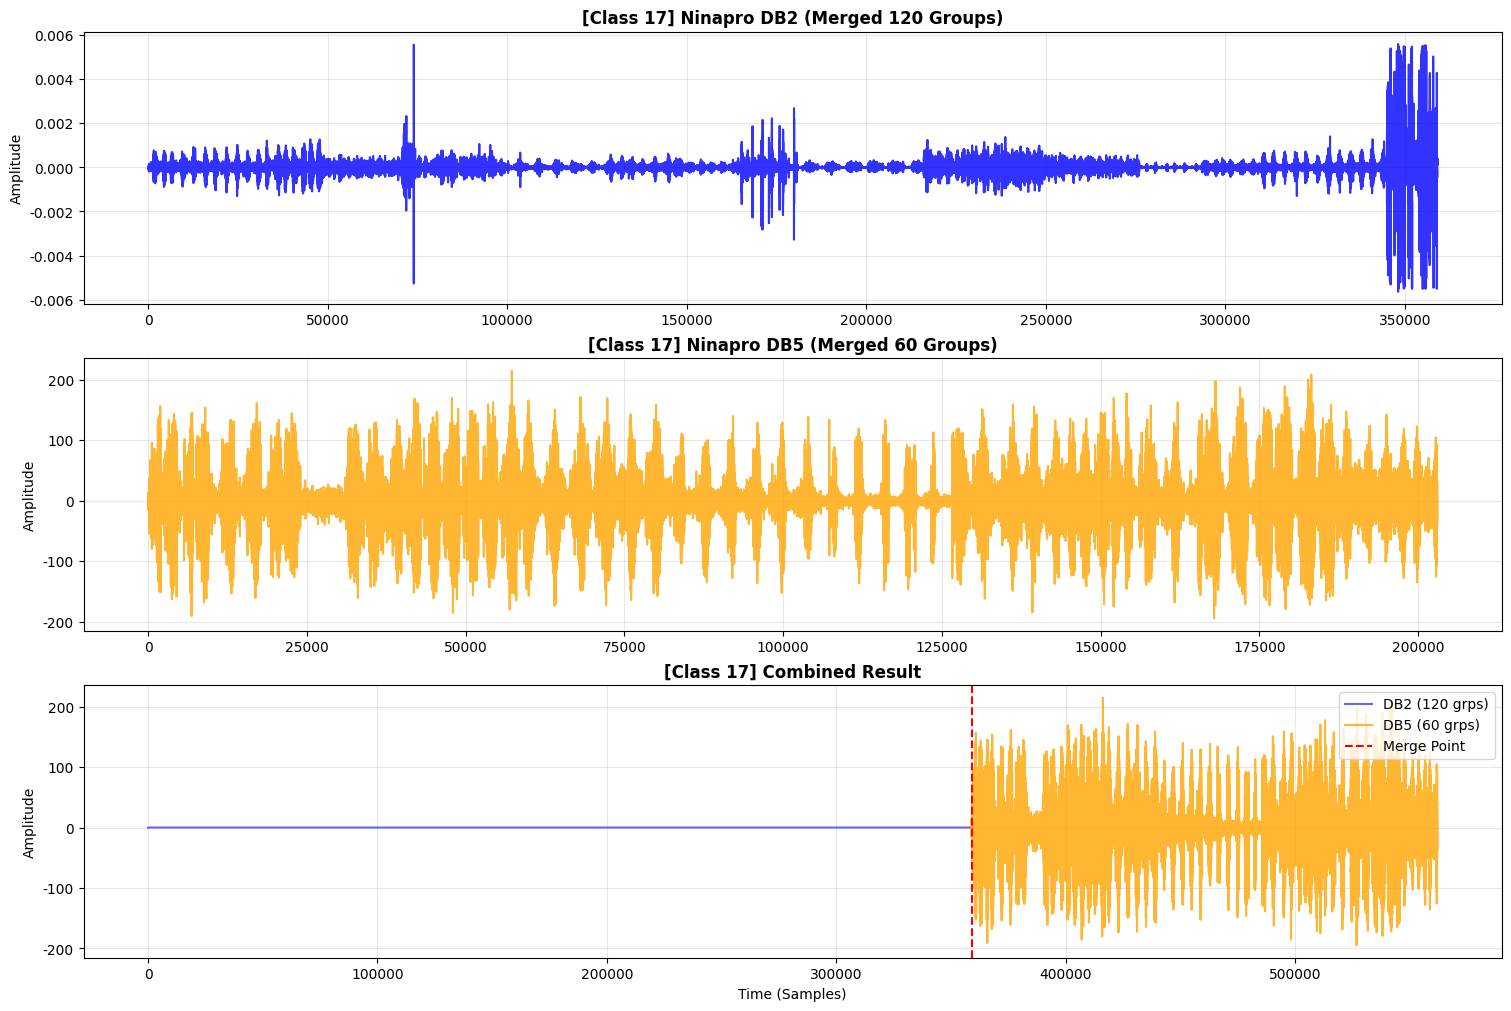

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging

# [설정] 폰트 및 로그 차단
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR) 
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['axes.unicode_minus'] = False 

# ==========================================
# 1. 설정
# ==========================================
sensor_idx_to_plot = 0  

if 'ninapro_df2' in locals() and 'ninapro_df5' in locals() and 'nature_df' in locals():
    emg_columns = [col for col in ninapro_df2.columns if col != 'Restimulus']
    target_col_name = emg_columns[sensor_idx_to_plot]

    classes_df2 = set(ninapro_df2['Restimulus'].unique())
    classes_df5 = set(ninapro_df5['Restimulus'].unique())
    classes_nature = set(nature_df['Restimulus'].unique())
    all_classes = sorted(list(classes_df2 | classes_df5 | classes_nature)) 

    print(f"총 {len(all_classes)}개의 클래스를 발견했습니다: {all_classes}")

    # ==========================================
    # 2. 반복 시각화
    # ==========================================
    for target_class in all_classes:
        
        # --------------------------------------
        # 데이터 추출 및 그룹 카운팅
        # --------------------------------------
        raw_df2 = ninapro_df2[ninapro_df2['Restimulus'] == target_class]
        raw_df5 = ninapro_df5[ninapro_df5['Restimulus'] == target_class]
        raw_df_nature = nature_df[nature_df['Restimulus'] == target_class]
        
        groups_count_2 = 0
        if not raw_df2.empty:
            groups_count_2 = 1 + (raw_df2.index.to_series().diff() > 1).sum()
            
        groups_count_5 = 0
        if not raw_df5.empty:
            groups_count_5 = 1 + (raw_df5.index.to_series().diff() > 1).sum()

        groups_count_nature = 0
        if not raw_df_nature.empty:
            groups_count_nature = 1 + (raw_df_nature.index.to_series().diff() > 1).sum()

        # 인덱스 초기화
        df2_subset = raw_df2[target_col_name].reset_index(drop=True)
        df5_subset = raw_df5[target_col_name].reset_index(drop=True)
        dfnature_subset = raw_df_nature[target_col_name].reset_index(drop=True)
        
        if df2_subset.empty and df5_subset.empty and dfnature_subset.empty:
            continue

        # [수정] 출력 라벨 오류 수정 (DB5 -> Nature)
        print(f"-" * 60)
        print(f"Label {target_class} 정보:")
        print(f"  - DB2   : {len(df2_subset)} samples ({groups_count_2} Groups)")
        print(f"  - DB5   : {len(df5_subset)} samples ({groups_count_5} Groups)")
        print(f"  - Nature: {len(dfnature_subset)} samples ({groups_count_nature} Groups)")
        print(f"  >>> 그래프 생성 중...")

        # --------------------------------------
        # 그래프 그리기 ([수정] 4행으로 변경)
        # --------------------------------------
        # 행을 4개로 늘려 각각(DB2, DB5, Nature) 그리고 마지막에 합친 것(Merged)을 그림
        
        fig, axes = plt.subplots(4, 1, figsize=(15, 14), constrained_layout=True)
        
        # [1] DB2 Plot (axes[0])
        if not df2_subset.empty:
            axes[0].plot(df2_subset, color='blue', alpha=0.8)
            axes[0].set_title(f'[Class {target_class}] Ninapro DB2', fontsize=12, fontweight='bold')
        else:
            axes[0].text(0.5, 0.5, "No Data in DB2", ha='center', va='center', fontsize=15)
            axes[0].set_title(f'[Class {target_class}] Ninapro DB2 (Missing)', fontsize=12, color='red')
        axes[0].set_ylabel('Amplitude')
        axes[0].grid(True, alpha=0.3)

        # [2] DB5 Plot (axes[1])
        if not df5_subset.empty:
            axes[1].plot(df5_subset, color='orange', alpha=0.8)
            axes[1].set_title(f'[Class {target_class}] Ninapro DB5', fontsize=12, fontweight='bold')
        else:
            axes[1].text(0.5, 0.5, "No Data in DB5", ha='center', va='center', fontsize=15)
            axes[1].set_title(f'[Class {target_class}] Ninapro DB5 (Missing)', fontsize=12, color='red')
        axes[1].set_ylabel('Amplitude')
        axes[1].grid(True, alpha=0.3)

        # [3] Nature Plot (axes[2]) - [수정] 별도 axes 사용 및 오타 수정
        if not dfnature_subset.empty:
            axes[2].plot(dfnature_subset, color='green', alpha=0.8) # 색상 구분 (Green)
            axes[2].set_title(f'[Class {target_class}] Nature DB', fontsize=12, fontweight='bold')
        else:
            axes[2].text(0.5, 0.5, "No Data in Nature DB", ha='center', va='center', fontsize=15)
            axes[2].set_title(f'[Class {target_class}] Nature DB (Missing)', fontsize=12, color='red')
        axes[2].set_ylabel('Amplitude')
        axes[2].grid(True, alpha=0.3)

        # [4] Merged Result (axes[3]) - [수정] 인덱스 계산 로직 수정
        # DB2 그리기
        current_idx = 0
        if not df2_subset.empty:
            axes[3].plot(np.arange(len(df2_subset)), df2_subset, 
                        color='blue', alpha=0.6, label='DB2')
            current_idx += len(df2_subset)
        
        # DB5 그리기 (DB2 뒤에 이어서)
        if not df5_subset.empty:
            axes[3].plot(np.arange(current_idx, current_idx + len(df5_subset)), df5_subset, 
                        color='orange', alpha=0.8, label='DB5')
            if current_idx > 0:
                axes[3].axvline(x=current_idx, color='red', linestyle='--', alpha=0.5)
            current_idx += len(df5_subset)
    
        # Nature 그리기 (DB5 뒤에 이어서) - [수정] 시작 인덱스 업데이트 반영
        if not dfnature_subset.empty:
            axes[3].plot(np.arange(current_idx, current_idx + len(dfnature_subset)), dfnature_subset, 
                        color='green', alpha=0.8, label='Nature')
            if current_idx > 0:
                axes[3].axvline(x=current_idx, color='red', linestyle='--', alpha=0.5)

        axes[3].set_title(f'[Class {target_class}] Combined Result (DB2 + DB5 + Nature)', fontsize=12, fontweight='bold')
        axes[3].set_xlabel('Time (Samples)')
        axes[3].set_ylabel('Amplitude')
        axes[3].legend(loc='upper right')
        axes[3].grid(True, alpha=0.3)

        plt.show() 
else:
    print("오류: 데이터프레임(ninapro_df2, ninapro_df5, nature_df)이 정의되지 않았습니다.")

In [ ]:
import pandas as pd

def print_max_min_exclude_zero(df, df_name):
    # 1. 연속된 그룹 식별 ID 생성
    group_id = (df['Restimulus'] != df['Restimulus'].shift()).cumsum()
    
    # 2. 그룹별 길이(size)와 라벨값(first) 추출
    group_info = df.groupby(group_id)['Restimulus'].agg(['size', 'first'])
    
    # -------------------------------------------------------
    # [기능 추가] Label 0 제외 필터링
    # -------------------------------------------------------
    # 라벨이 0이 아닌 그룹만 남깁니다.
    target_groups = group_info[group_info['first'] != 0]
    
    if target_groups.empty:
        print(f"[{df_name}] Label 0을 제외하면 남는 데이터가 없습니다.")
        return

    # 3. 최대/최소값 찾기 (필터링된 데이터 기준)
    max_len = target_groups['size'].max()
    min_len = target_groups['size'].min()
    
    # 해당 길이의 라벨 찾기
    max_label = target_groups.loc[target_groups['size'].idxmax(), 'first']
    min_label = target_groups.loc[target_groups['size'].idxmin(), 'first']
    
    print(f"📊 [{df_name}] 분석 결과 (Label 0 제외)")
    print(f"----------------------------------------")
    print(f"최대 길이: {max_len} (Label: {max_label})")
    print(f"최소 길이: {min_len} (Label: {min_label})")
    print(f"분석된 그룹 수: {len(target_groups)} (전체 {len(group_info)}개 중)")
    print(f"----------------------------------------\n")

# --- 실행 ---
print_max_min_exclude_zero(ninapro_df2, "ninapro_df2")
print_max_min_exclude_zero(ninapro_df5, "ninapro_df5")
print_max_min_exclude_zero(nature_df, "nature_df")


In [ ]:
import pandas as pd

def force_fixed_length_with_stitching(df, target_length=2000):
    """
    모든 그룹을 target_length로 만듭니다.
    - 긴 경우: 2000개 자르고, 남은 것은 '대기열(Buffer)'에 넣습니다.
    - 짧은 경우: '대기열'에 있는 데이터와 합쳐서 2000을 만듭니다.
    - 그래도 부족하면: 다음 데이터가 올 때까지 대기열에서 기다립니다.
    """
    # 1. 그룹 식별
    group_id = (df['Restimulus'] != df['Restimulus'].shift()).cumsum()
    
    processed_list = []
    
    # [핵심] 라벨별로 자투리 데이터를 모아둘 저장소 (Dictionary)
    # 예: { Label_1: DataFrame, Label_2: DataFrame ... }
    label_buffer = {}
    
    print(f"--- 길이 고정 및 이어붙이기 작업 시작 (Target: {target_length}) ---")
    
    # 2. 그룹별 순회
    for gid, segment in df.groupby(group_id):
        label = segment['Restimulus'].iloc[0] # 현재 그룹의 동작 라벨
        
        # (1) 해당 라벨의 버퍼가 비어있으면 새로 생성
        if label not in label_buffer:
            label_buffer[label] = pd.DataFrame()
            
        # (2) 현재 구간을 버퍼(대기열) 뒤에 추가
        #     이전 그룹에서 남은 자투리 뒤에 현재 데이터를 붙이는 개념
        label_buffer[label] = pd.concat([label_buffer[label], segment])
        
        # (3) 버퍼에 데이터가 2000개 이상 쌓였는지 확인 (반복)
        while len(label_buffer[label]) >= target_length:
            # 2000개만큼 뚝 떼어내기
            complete_segment = label_buffer[label].iloc[:target_length].copy()
            
            # 인덱스 깔끔하게 초기화 (0 ~ 1999)
            complete_segment = complete_segment.reset_index(drop=True)
            
            # 결과 리스트에 저장
            processed_list.append(complete_segment)
            
            # 버퍼 업데이트 (앞에 쓴 2000개는 버리고 남은 뒷부분만 남김)
            label_buffer[label] = label_buffer[label].iloc[target_length:]
            
    # 3. 병합 및 반환
    if processed_list:
        new_df = pd.concat(processed_list).reset_index(drop=True)
        
        # 통계 출력
        print(f"-> 처리 완료. 생성된 2000길이 샘플 수: {len(processed_list)}개")
        
        # (선택사항) 아직 버퍼에 남아서 2000이 안 되어 버려진 데이터 확인
        total_leftover = sum([len(buf) for buf in label_buffer.values()])
        print(f"-> (참고) 짝을 못 맞춰 버려진 자투리 데이터 총합: {total_leftover}개")
        
        return new_df
    else:
        return pd.DataFrame(columns=df.columns)

# ---------------------------------------------------------
# 실행 및 결과 저장
# ---------------------------------------------------------

# ninapro_df2 적용
print("\nProcessing 'ninapro_df2'...")
ninapro_df2 = force_fixed_length_with_stitching(ninapro_df2, target_length=2000)

# ninapro_df5 적용
print("\nProcessing 'ninapro_df5'...")
ninapro_df5 = force_fixed_length_with_stitching(ninapro_df5, target_length=2000)

# nature_df 적용
print("\nProcessing 'nature_df'...")
nature_df = force_fixed_length_with_stitching(nature_df, target_length=2000)

# ---------------------------------------------------------
# 결과 검증
# ---------------------------------------------------------
def check_length_stats(df, name):
    if len(df) == 0:
        print(f"[{name}] 데이터가 없습니다.")
        return
    # 이제 단순히 Restimulus로 묶으면 안되고(이어붙여서 섞였을 수 있음), 
    # 인덱스나 개수로 확인해야 합니다. 여기서는 전체 길이를 2000으로 나눠서 확인.
    
    total_len = len(df)
    is_perfect = (total_len % 2000) == 0
    
    print(f"\n📊 [{name}] 최종 검증")
    print(f"  - 전체 데이터 길이: {total_len}")
    print(f"  - 2000 단위로 딱 떨어집니까? : {is_perfect}")
    if is_perfect:
        print(f"  - 총 샘플 개수: {total_len // 2000}개")

check_length_stats(ninapro_df2, "ninapro_df2")
check_length_stats(ninapro_df5, "ninapro_df5")
check_length_stats(nature_df, "nature_df")


Processing 'ninapro_df2'...
--- 길이 고정 및 이어붙이기 작업 시작 (Target: 2000) ---
-> 처리 완료. 생성된 2000길이 샘플 수: 8025개
-> (참고) 짝을 못 맞춰 버려진 자투리 데이터 총합: 11000개

Processing 'ninapro_df5'...
--- 길이 고정 및 이어붙이기 작업 시작 (Target: 2000) ---
-> 처리 완료. 생성된 2000길이 샘플 수: 4547개
-> (참고) 짝을 못 맞춰 버려진 자투리 데이터 총합: 9000개

📊 [ninapro_df2] 최종 검증
  - 전체 데이터 길이: 16050000
  - 2000 단위로 딱 떨어집니까? : True
  - 총 샘플 개수: 8025개

📊 [ninapro_df5] 최종 검증
  - 전체 데이터 길이: 9094000
  - 2000 단위로 딱 떨어집니까? : True
  - 총 샘플 개수: 4547개


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ---------------------------------------------------------
# 1. [핵심] 데이터셋별 개별 정규화 (Scale Matching)
# ---------------------------------------------------------
print("=== 1. 데이터셋별 개별 정규화 (스케일 통일) ===")

def scale_features_only(df):
    """라벨(Restimulus)은 건드리지 않고, 센서 데이터만 정규화합니다."""
    # 마지막 컬럼(라벨)을 제외한 센서 데이터만 추출
    features = df.iloc[:, :-1].values 
    labels = df.iloc[:, -1].values    
    
    # 정규화 (평균 0, 표준편차 1로 변환)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # 다시 DataFrame으로 합치기
    df_scaled = pd.DataFrame(features_scaled, columns=df.columns[:-1])
    df_scaled['Restimulus'] = labels
    return df_scaled

# DB2와 DB5를 각각 정규화합니다. (이제 25,000배 차이가 사라집니다)
print("DB2 정규화 진행 중...")
ninapro_df2_scaled = scale_features_only(ninapro_df2)

print("DB5 정규화 진행 중...")
ninapro_df5_scaled = scale_features_only(ninapro_df5)

print("nature 정규화 진행 중...")
nature_df_scaled = scale_features_only(nature_df)


print("✅ 개별 정규화 완료!")

# ---------------------------------------------------------
# 2. 3D 변환 및 병합 (TIME_STEPS=50)
# ---------------------------------------------------------
print("\n=== 2. 3D 데이터 변환 및 병합 ===")
TIME_STEPS = 50  # 200Hz 기준 0.25초 (최적 길이)

def create_3d_dataset(df, time_steps):
    # 데이터 길이를 50의 배수로 맞춤 (자투리 제거)
    cutoff = (len(df) // time_steps) * time_steps
    df = df.iloc[:cutoff]
    
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    n_samples = len(X) // time_steps
    
    # (샘플 수, 시간, 센서) 형태로 변환
    X_3d = X.reshape(n_samples, time_steps, X.shape[1])
    # 라벨 (윈도우의 첫 번째 값 사용)
    y_sampled = y[::time_steps]
    
    return X_3d, y_sampled

# 변환 수행
X_db2, y_db2 = create_3d_dataset(ninapro_df2_scaled, TIME_STEPS)
X_db5, y_db5 = create_3d_dataset(ninapro_df5_scaled, TIME_STEPS)
X_na, y_na = create_3d_dataset(nature_df_scaled, TIME_STEPS)



# 두 데이터를 하나로 합치기
X_final = np.concatenate([X_db2, X_db5, X_na], axis=0)
y_final = np.concatenate([y_db2, y_db5, y_na], axis=0)

print(f"최종 데이터 Shape: {X_final.shape}")

# ---------------------------------------------------------
# 3. 데이터 분할 (Train/Val/Test)
# ---------------------------------------------------------
print("\n=== 3. 학습/검증/테스트 데이터 분할 ===")
y_onehot = to_categorical(y_final)

# 1차 분할: Train+Val (80%) / Test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_final, y_onehot, test_size=0.2, random_state=42, stratify=y_final
)

# 2차 분할: Train (80%) / Val (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=np.argmax(y_train_val, axis=1)
)

print(f"✅ 데이터 준비 완료!")
print(f"학습용(Train): {X_train.shape} (여기서 신호가 살아있어야 함)")
print(f"검증용(Val)  : {X_val.shape}")
print(f"평가용(Test) : {X_test.shape}")

=== 1. 데이터셋별 개별 정규화 (스케일 통일) ===
DB2 정규화 진행 중...
DB5 정규화 진행 중...
✅ 개별 정규화 완료!

=== 2. 3D 데이터 변환 및 병합 ===
최종 데이터 Shape: (50288, 500, 16)

=== 3. 학습/검증/테스트 데이터 분할 ===
✅ 데이터 준비 완료!
학습용(Train): (32184, 500, 16) (여기서 신호가 살아있어야 함)
검증용(Val)  : (8046, 500, 16)
평가용(Test) : (10058, 500, 16)


In [ ]:
import numpy as np

print("=== 정규화 후 스케일 재확인 ===")

# 1. DB2 정규화 데이터 확인
if 'ninapro_df2_scaled' in locals():
    # 라벨 제외하고 센서값만 추출
    db2_vals = ninapro_df2_scaled.iloc[:, :-1].values
    db2_mean = np.mean(np.abs(db2_vals))
    db2_std = np.std(db2_vals)
    
    print(f"\n[DB2 Scaled]")
    print(f"  - 평균 신호 강도 (절대값): {db2_mean:.4f}")
    print(f"  - 표준편차: {db2_std:.4f} (1.0에 가까워야 함)")
else:
    print("\n'ninapro_df2_scaled' 변수가 없습니다. 정규화 코드를 먼저 실행해주세요.")

# 2. DB5 정규화 데이터 확인
if 'ninapro_df5_scaled' in locals():
    db5_vals = ninapro_df5_scaled.iloc[:, :-1].values
    db5_mean = np.mean(np.abs(db5_vals))
    db5_std = np.std(db5_vals)
    
    print(f"\n[DB5 Scaled]")
    print(f"  - 평균 신호 강도 (절대값): {db5_mean:.4f}")
    print(f"  - 표준편차: {db5_std:.4f} (1.0에 가까워야 함)")
else:
    print("\n'ninapro_df5_scaled' 변수가 없습니다.")

# 3. 비교
if 'ninapro_df2_scaled' in locals() and 'ninapro_df5_scaled' in locals():
    ratio = db5_mean / db2_mean if db2_mean != 0 else 0
    print(f"\n--------------------------------------------------")
    print(f" 결과: 스케일 비율이 약 [{ratio:.2f}배] 입니다.")
    
    if 0.5 < ratio < 2.0:
        print("[성공] 두 데이터의 체급이 비슷해졌습니다! 이제 합쳐도 안전합니다.")
    else:
        print("[주의] 아직도 스케일 차이가 좀 있습니다. 정규화 코드를 다시 확인하세요.")

=== 🔍 정규화 후 스케일 재확인 ===

[DB2 Scaled]
  - 평균 신호 강도 (절대값): 0.2475
  - 표준편차: 0.8660 (1.0에 가까워야 함)

[DB5 Scaled]
  - 평균 신호 강도 (절대값): 0.4603
  - 표준편차: 1.0000 (1.0에 가까워야 함)

--------------------------------------------------
 결과: 스케일 비율이 약 [1.86배] 입니다.
[성공] 두 데이터의 체급이 비슷해졌습니다! 이제 합쳐도 안전합니다.


=== 전체 라벨(18개) 신호 상태 점검 ===

[1] 라벨별 평균 진폭(Activity) 확인
Label  | Status     | Mean Peak-to-Peak    | Sample Count
-------------------------------------------------------
0      | OK         | 1.3817               | 17556
1      | OK         | 3.2801               | 1142
2      | OK         | 3.8332               | 980
3      | OK         | 5.2208               | 883
4      | OK         | 5.6207               | 855
5      | OK         | 5.1717               | 766
6      | OK         | 5.9918               | 725
7      | OK         | 2.9253               | 1060
8      | OK         | 4.2797               | 860
9      | OK         | 4.5430               | 934
10     | OK         | 4.8403               | 899
11     | OK         | 4.4528               | 981
12     | OK         | 5.5145               | 819
13     | OK         | 8.3020               | 699
14     | OK         | 6.0850               | 668
15     | OK         | 3.9435               | 778
16     | OK         | 6.9844              

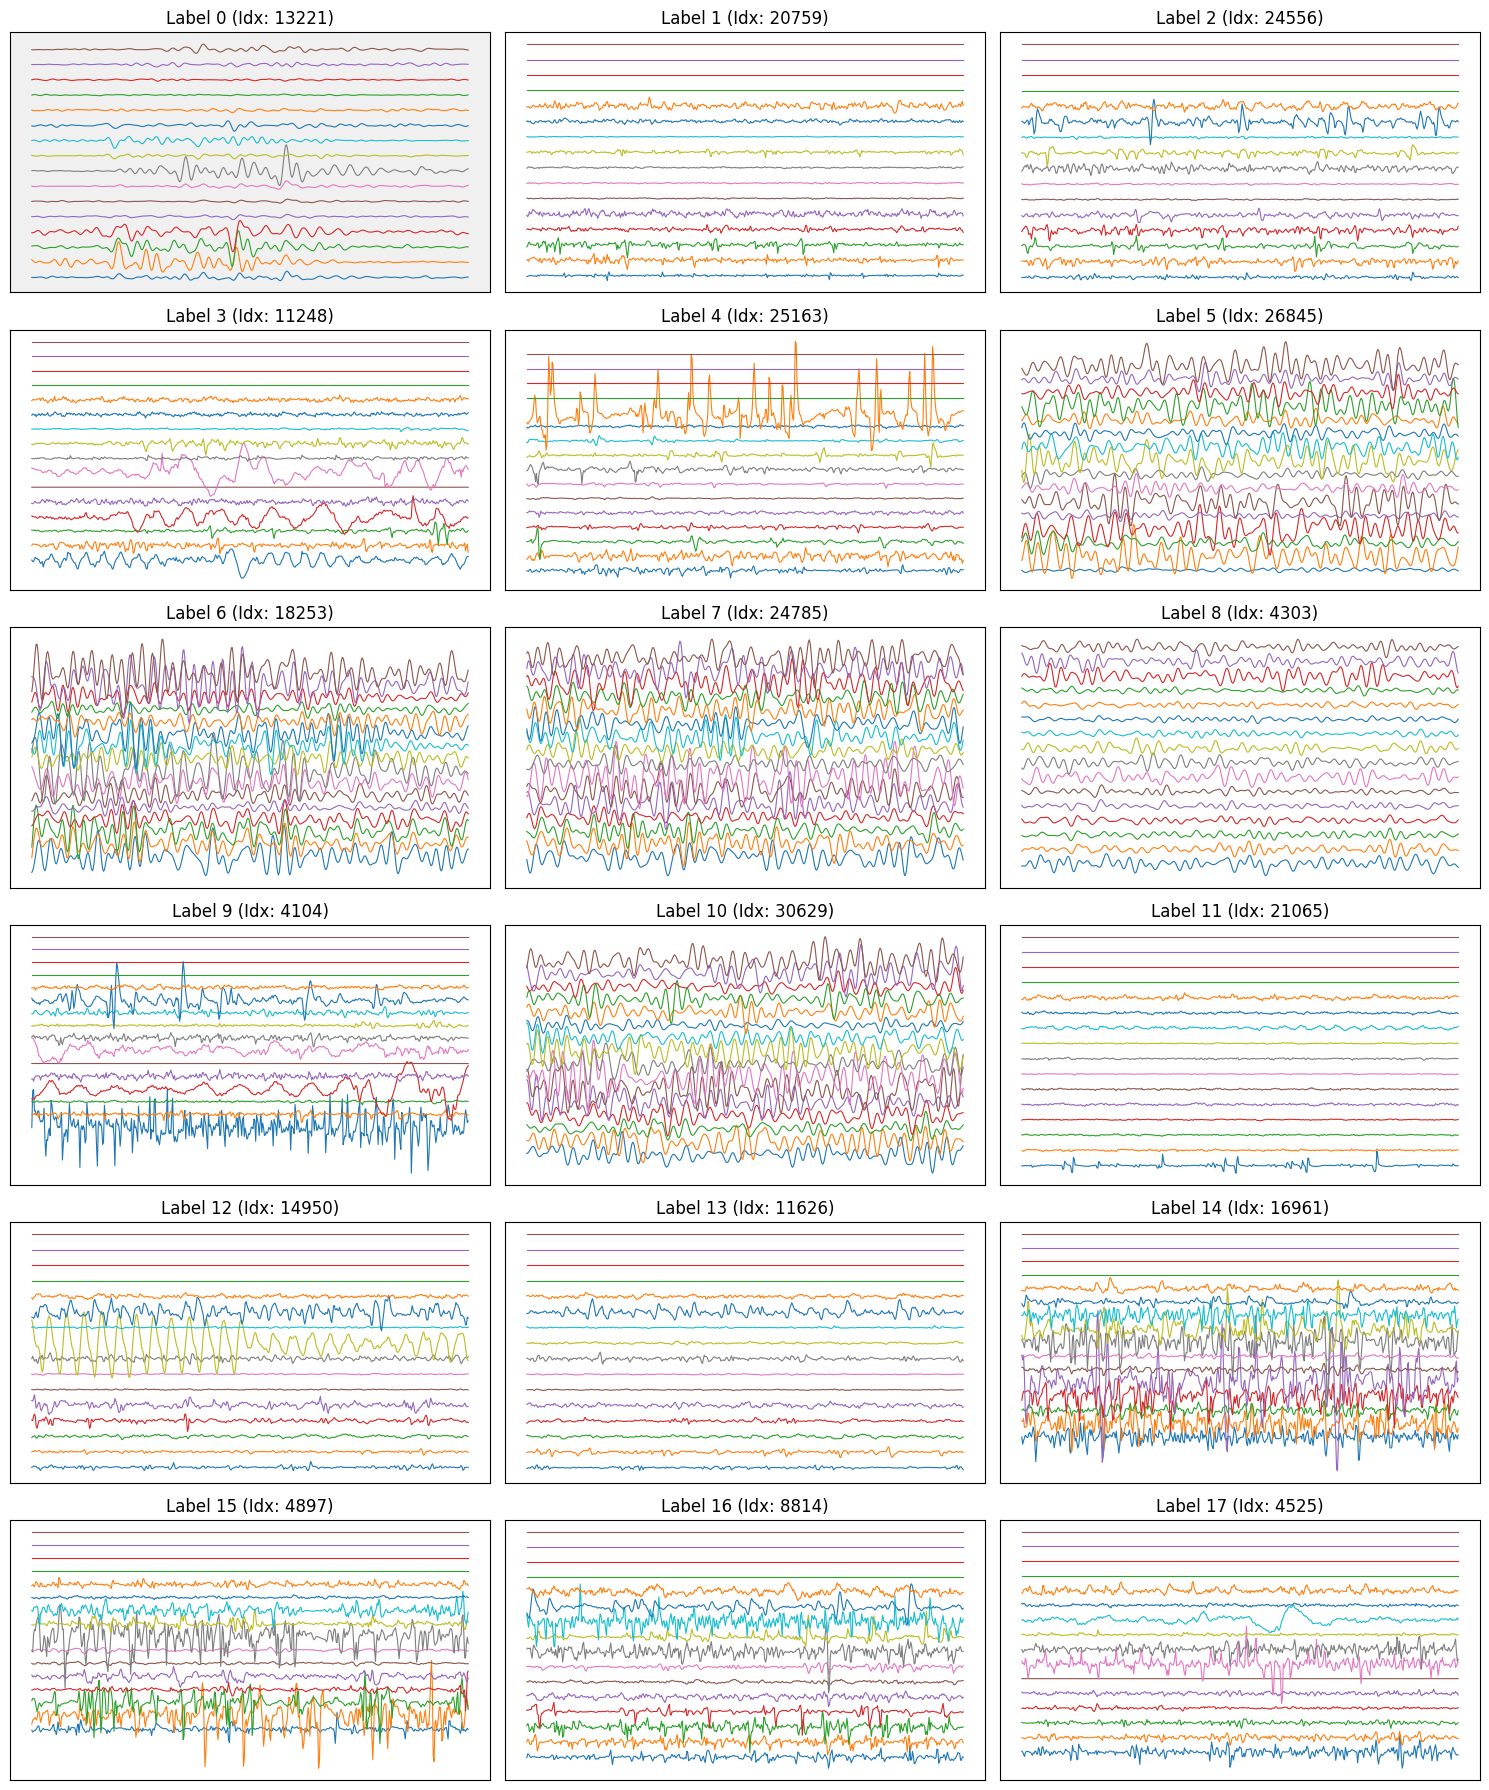

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

def check_all_labels(X, y):
    # 1. 라벨 변환 (One-hot -> Integer)
    if y.ndim > 1:
        y_int = np.argmax(y, axis=1)
    else:
        y_int = y
        
    unique_labels = np.sort(np.unique(y_int))
    num_classes = len(unique_labels)
    
    print(f"=== 🔎 전체 라벨({num_classes}개) 신호 상태 점검 ===")
    
    # -------------------------------------------------------
    # 1. 수치 리포트 (건강 검진)
    # -------------------------------------------------------
    print("\n[1] 라벨별 평균 진폭(Activity) 확인")
    print(f"{'Label':<6} | {'Status':<10} | {'Mean Peak-to-Peak':<20} | {'Sample Count':<10}")
    print("-" * 55)
    
    for label in unique_labels:
        # 해당 라벨의 모든 데이터 인덱스
        indices = np.where(y_int == label)[0]
        
        if len(indices) == 0:
            print(f"{label:<6} | ❌ EMPTY    | -                    | 0")
            continue
            
        # 해당 라벨 데이터 전체의 평균 진폭 계산 (샘플링하여 계산 속도 향상)
        # 100개만 뽑아서 통계 냄
        sample_indices = np.random.choice(indices, min(len(indices), 100), replace=False)
        samples = X[sample_indices]
        
        # (최대 - 최소)의 평균 계산
        p2p = np.mean(np.max(samples, axis=1) - np.min(samples, axis=1))
        
        status = "✅ OK" if p2p > 0.5 else ("⚠️ Weak" if p2p > 0.1 else "💀 Flat")
        if label == 0 and p2p < 1.0: status = "💤 Rest" # 휴식은 원래 약함
        
        print(f"{label:<6} | {status:<10} | {p2p:.4f}               | {len(indices)}")

    # -------------------------------------------------------
    # 2. 그리드 시각화 (눈으로 확인)
    # -------------------------------------------------------
    print("\n[2] 라벨별 파형 시각화 (랜덤 1개 샘플)")
    
    cols = 3
    rows = math.ceil(num_classes / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten() # 반복문 돌리기 쉽게 1차원으로 폅니다
    
    for i, label in enumerate(unique_labels):
        ax = axes[i]
        
        # 해당 라벨의 데이터 중 하나 랜덤 선택
        indices = np.where(y_int == label)[0]
        if len(indices) == 0:
            ax.text(0.5, 0.5, "No Data", ha='center', va='center')
            continue
            
        idx = np.random.choice(indices)
        data = X[idx] # (50, 16)
        
        # 16개 채널 겹쳐 그리기 (Offset 적용)
        offset = 0
        gap = 4 # 그래프 간격
        for ch in range(data.shape[1]):
            ax.plot(data[:, ch] + offset, linewidth=0.8)
            offset += gap
            
        ax.set_title(f"Label {label} (Idx: {idx})")
        ax.set_xticks([]) # X축 눈금 숨김 (깔끔하게)
        ax.set_yticks([]) # Y축 눈금 숨김
        ax.grid(True, alpha=0.2)
        
        # 배경색으로 상태 표시 (휴식=회색, 동작=흰색)
        if label == 0:
            ax.set_facecolor('#f0f0f0') 

    # 남은 빈 칸 끄기
    for i in range(num_classes, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

# === 실행 ===
if 'X_train' in locals():
    check_all_labels(X_train, y_train)
else:
    print("X_train 데이터가 없습니다.")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, BatchNormalization, Activation, Concatenate, MaxPooling2D, Reshape, Multiply, Lambda, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K

# =========================================================
# GPU 스코프 내에서 실행 (Mac M4 가속)
# =========================================================
with tf.device('/device:GPU:0'):

    # -----------------------------------------------------
    # 1. Temporal Attention Layer (수정됨)
    # -----------------------------------------------------
    def temporal_attention_layer(x):
        """
        Input Shape: (Batch, Time, Features)
        중요한 시간(Time Step)에 가중치를 부여하여 합칩니다.
        """
        # (1) Score 계산: x -> Dense -> Tanh -> Dense -> Softmax
        d_model = x.shape[-1]
        
        # Query
        score = Dense(d_model // 2, activation='tanh')(x)
        # Score
        score = Dense(1)(score) # (Batch, Time, 1)
        
        # [수정] Activation('softmax', axis=1) -> Softmax(axis=1)
        # Time 축(axis=1)을 기준으로 확률값을 계산합니다.
        attention_weights = Softmax(axis=1)(score)
        
        # (2) Context Vector 계산 (Weighted Sum)
        context = Multiply()([x, attention_weights])
        context = Lambda(lambda z: K.sum(z, axis=1))(context) # Sum over time
        
        return context

    # -----------------------------------------------------
    # 2. CWE-Inception Block
    # -----------------------------------------------------
    def cwe_inception_block(x, filters):
        """
        Channel-wise Encoder를 위한 Inception 블록입니다.
        """
        # Branch 1: Small Kernel
        b1 = Conv2D(filters, (15, 1), padding='7', activation='relu')(x)
        b1 = BatchNormalization()(b1)
        
        # Branch 2: Medium Kernel
        b2 = Conv2D(filters, (51, 1), padding='25', activation='relu')(x)
        b2 = BatchNormalization()(b2)
        
        # Branch 3: Large Kernel
        b3 = Conv2D(filters, (101, 1), padding='50', activation='relu')(x)
        b3 = BatchNormalization()(b3)
        
        # Branch 4: MaxPool + 1x1 Conv
        b4 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(x)
        b4 = Conv2D(filters, (1, 1), padding='same', activation='relu')(b4)
        b4 = BatchNormalization()(b4)
        
        # Concatenate
        out = Concatenate(axis=-1)([b1, b2, b3, b4])
        return out

    # -----------------------------------------------------
    # 3. 전체 모델 조립
    # -----------------------------------------------------
    def build_cwe_inception_attn_model(input_shape, num_classes):
        # Input: (50, 16)
        inputs = Input(shape=input_shape)
        
        # [CWE 준비] (Batch, Time, Sensors, 1) 이미지처럼 변환
        x = Reshape((input_shape[0], input_shape[1], 1))(inputs)
        
        # --- [Stem Layer] ---
        x = Conv2D(32, (7, 1), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 1), padding='same')(x) # Time축만 절반으로 줄임
        
        # --- [Inception Block 1] ---
        x = cwe_inception_block(x, filters=16) 
        x = MaxPooling2D((2, 1), padding='same')(x)
        x = Dropout(0.2)(x)
        
        # --- [Inception Block 2] ---
        x = cwe_inception_block(x, filters=32)
        x = MaxPooling2D((2, 1), padding='same')(x)
        x = Dropout(0.3)(x)
        
        # --- [Feature Integration] ---
        # Reshape to (Batch, Time, Features)
        new_shape = (-1, x.shape[2] * x.shape[3]) 
        x = Reshape((x.shape[1], new_shape[1]))(x)
        
        # 1x1 Conv로 차원 축소
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        
        # --- [Temporal Attention] ---
        x = temporal_attention_layer(x)
        
        # --- [Classifier] ---
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.4)(x)
        outputs = Dense(num_classes, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=outputs, name="CWE_Inception_Attn")
        
        optimizer = Adam(learning_rate=0.001)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model

    # -----------------------------------------------------
    # 4. 모델 생성 및 학습 설정
    # -----------------------------------------------------
    input_shape = (X_train.shape[1], X_train.shape[2]) # (50, 16)
    num_classes = y_train.shape[1]
    
    model_cwe_ia = build_cwe_inception_attn_model(input_shape, num_classes)
    model_cwe_ia.summary()

    # 콜백
    early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    checkpoint = ModelCheckpoint('best_cwe_inception_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

    print("\n[M4 GPU] CWE-Inception-Attention 모델 학습 시작...")
    
    # 학습
    history_cwe_ia = model_cwe_ia.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=1000,
        batch_size=128,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        verbose=1
    )

print("\n학습 완료")

Model: "CWE_Inception_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 500, 16)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 500, 16,   │          0 │ input_layer_3[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 500, 16,   │        256 │ reshape_6[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 16,   │        128 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 250, 16,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 250, 16,   │          0 │ max_pooling2d_15… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 250, 16,   │      7,696 │ max_pooling2d_15… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 250, 16,   │     26,128 │ max_pooling2d_15… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 250, 16,   │     51,728 │ max_pooling2d_15… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 250, 16,   │        528 │ max_pooling2d_16… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 16,   │         64 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 16,   │         64 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 16,   │         64 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 16,   │         64 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 250, 16,   │          0 │ batch_normalizat… │
│ (Concatenate)       │ 64)               │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 125, 16,   │          0 │ concatenate_6[0]… │
│ (MaxPooling2D)      │ 64)               │            │                 

 Total params: 740,179 (2.82 MB)

 Trainable params: 739,475 (2.82 MB)

 Non-trainable params: 704 (2.75 KB)


[M4 GPU] CWE-Inception-Attention 모델 학습 시작...
Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.5557 - loss: 1.7692
Epoch 1: val_accuracy improved from None to 0.30736, saving model to best_cwe_inception_model.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 142s 550ms/step - accuracy: 0.5812 - loss: 1.6325 - val_accuracy: 0.3074 - val_loss: 2.1700 - learning_rate: 0.0010
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.6010 - loss: 1.5234
Epoch 2: val_accuracy improved from 0.30736 to 0.62590, saving model to best_cwe_inception_model.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 141s 558ms/step - accuracy: 0.5999 - loss: 1.5389 - val_accuracy: 0.6259 - val_loss: 1.3452 - learning_rate: 0.0010
Epoch 3/100
 18/252 ━━━━━━━━━━━━━━━━━━━━ 2:05 536ms/step - accuracy: 0.6209 - loss: 1.4943

KeyboardInterrupt: 

In [ ]:

# ---------------------------------------------------------
# 5. 결과 시각화
# ---------------------------------------------------------
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history_cwe_ia)

# ---------------------------------------------------------
# 6. 최종 테스트 평가
# ---------------------------------------------------------
test_loss, test_acc = model_cwe_ia.evaluate(X_test, y_test, verbose=0)
print(f"\n🏆 최종 테스트 정확도: {test_acc*100:.2f}%")